# AIML Assignment 2: Time Series Analysis on Pollutant Gases
## Problem Statement
![Air Pollution](https://assets.nrdc.org/sites/default/files/styles/header_background/public/health4_26_airpollguide_istock_2796602_900x600px.jpg?itok=vCwn8tgz)

Air pollution is a problem that affects major cities around the world. There are many different types of air pollutants, which usually come in the form of gases like carbon monoxide, carbon dioxide, sulfur dioxide, nitrogen oxides, CFCss, and other chemicals. 

Bad air quality in cities can lead to health problems for residents living there, including respiratory diseases and even death. In fact, according to the World Health Organisation, air pollution accounts for 4.2 million deaths every year [[1]](https://www.who.int/health-topics/air-pollution#tab=tab_1). To keep track of air pollution, governments invest heavily in sensors, which are used to measure the level of air pollution of different pollutants. However, good quality sensors are expensive, and thus governments rely on cheap sensors which have low accuracy. [[2]](https://ink.library.smu.edu.sg/cgi/viewcontent.cgi?article=5536&context=sis_research)

Our task is to create a time series model that is capable of forecasting air pollution levels. If our model can forecast air pollution data with a reasonable accuracy, it would be a valuable tool (more accurate than low quality sensors) for health authorities to guage the impact of air pollution, and warn the public of any health threats. 

To be more concrete, our task is to predict the average sensor response of Carbon Monoxide, Non Metanic HydroCarbons, Nitrogen Oxides, and Ozone. (Note that sensor response is not the same as the concentration.)

### Carbon Monoxide (CO)
Carbon monoxide (CO)—a colorless, odorless, tasteless, and toxic air pollutant—is produced in the incomplete combustion of carbon-containing fuels, such as gasoline, natural gas, oil, coal, and wood. Breathing the high concentrations of CO typical of a polluted environment leads to reduced oxygen (O2) transport by hemoglobin and has health effects that include headaches, increased risk of chest pain for persons with heart disease, and impaired reaction timing. [[3]](https://www.nap.edu/read/10378/chapter/3)

## Data Understanding
The dataset appears to be sourced from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Air+Quality), but with data downsampled from an hourly frequency to a daily frequency, and several features omitted. The description and date range of the data appears to match up, the scales of the data are the same,and even the method of marking missing values is the same. Furthermore, downsampling that dataset leads to a dataset that has a similar size as the one provided. 

If we make an assumption that the data set is the same, we can say that the data was collected from chemical sensor data collected over the course of March 2004 to February 2005. [[4]](https://www.sciencedirect.com/science/article/abs/pii/S0925400507007691?via%3Dihub)

![Operation of a MOS Type Gas Sensor](https://www.figaro.co.jp/en/img/development/handoutai/shikumi.gif)

The sensors used are metal oxide sensors, which use a sensing layer, where gases are either absorbed or desorbed. This reaction causes a change in the conductivity of the material. [[4]](https://www.sciencedirect.com/science/article/abs/pii/S0925400507007691?via%3Dihub). The sensor device then uses this reading to estimate the concentration of that particular gas in the surroundings.

Our dataset contains the following attributes:
| Attribute | Description |
|---|---|
| Date | Day/Month/Year Format, which is different from default Pandas format |
| T | Temperature in Degree Celcius |
| RH | Relative Humidity (%) |
| Gas | Type of Gas Measured: CO (Carbon Monoxide), NMHC (Non Metanic HydroCarbons), NOx (Nitrogen Oxides), O3 (Ozone) |
| Value | Daily Averaged Estimated Concentration of Pollutants. Note that the concentration for Carbon Monoxide would be in a different unit |

Our target attribute would be the `Value` attribute.
## References
- AIML Module Notes
- Hyndman, R.J., & Athanasopoulos, G. (2021) Forecasting: principles and practice, 3rd edition, OTexts: Melbourne, Australia. OTexts.com/fpp3. 
- Statsmodels Documentation
- Pandas documentation
- Scikit Learn documentation
- Wiley Data Analyst Time Series and Forecasting Notes
- [World Health Organisation](https://www.who.int/health-topics/air-pollution#tab=tab_1)
- MAAH, Balz; ZHOU, Zimu; and THIELE, Lothar. A survey on sensor calibration in air pollution monitoring 
deployments. (2018). IEEE Internet of Things. 5, (6), 4857-4870. Research Collection School Of 
Information Systems. 
- [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Air+Quality)
- [S. De Vito, E. Massera, M. Piga, L. Martinotto, G. Di Francia,
On field calibration of an electronic nose for benzene estimation in an urban pollution monitoring scenario](https://www.researchgate.net/publication/235641830_On_field_calibration_of_an_electronic_nose_for_benzene_estimation_in_an_urban_pollution_monitoring_scenario)
- [Climate of Italy](https://en.wikipedia.org/wiki/Climate_of_Italy)
- [Nitrogen Oxide Emission Trends for Italy](https://www.statista.com/statistics/809161/nitrogen-oxides-nox-emission-trend-in-italy/)
- [NOx Emissions - European Environment Agency](https://www.eea.europa.eu/data-and-maps/indicators/eea-32-nitrogen-oxides-nox-emissions-1/assessment.2010-08-19.0140149032-3#:~:text=The%20sectors%20responsible%20for%20the,distribution%27%20(contributing%2027%25).)
- [Effect of Environmental Temperature and Humidity
on Different Metal Oxide Gas Sensors at Various
Gas Concentration Levels, Abdulnasser Nabil Abdullah et al 2020 IOP Conf. Ser.: Mater. Sci. Eng. 864
012152](https://iopscience.iop.org/article/10.1088/1757-899X/864/1/012152/pdf)
- [Choosing the order of an ARIMA model](https://arauto.readthedocs.io/en/latest/how_to_choose_terms.html#the-acf-and-pacf-function)
- [Using Pearson Correlation Correctly With Time Series](https://stats.stackexchange.com/questions/133155/how-to-use-pearson-correlation-correctly-with-time-series)

## Library Imports

In [1]:
# Utility
from os import path
from os.path import exists # We use this to check if a file exists
from tqdm import tqdm # Use this to track how much time each iter of a for loop takes
import warnings # Statsmodels likes to throw out warnings. Some of them are important, some are not
from statsmodels.tools.sm_exceptions import *
from collections import defaultdict 
from statsmodels.api import load # load serialized models

# Statistical Analysis
## General
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm

## Time Series
from statsmodels.tsa.seasonal import STL, seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing, Holt

## Model Validation
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error


# Graphical Plots
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

sns.set()
plt.rcParams['figure.figsize'] = (13, 8)

## Data Ingestion
We will start out by loading in our data. We must take note here that the date formatting of the data does not follow the standard Pandas convention. As such, we must specify the date formatting to convert the date attribute to a datetime.

Since many Pandas time series methods only work if the index of our data is a time series, we will set the date attribute as the index.

Also, we will set all -200 values as missing values, as specified in the dataset source.

In [2]:
df = pd.read_csv("train.csv", na_values=[-200])
df["Date"] = pd.to_datetime(df["Date"], format="%d/%m/%Y")
df.set_index("Date", inplace=True)
df.head()

T         RH Gas        Value
Date                                             
2004-03-10  12.020833  54.883334  CO  1316.500000
2004-03-11   9.833333  64.069791  CO  1244.062500
2004-03-12  11.292708  51.107292  CO  1281.562500
2004-03-13  12.866319  51.530903  CO  1330.555556
2004-03-14  16.016667  48.843750  CO  1360.927083

### Pivoting from Long to Wide Format
The form of our data is in a long format. For easier analysis later, we will pivot the data to a wide format, with a column for each row.

In [3]:
df_pivot = pd.pivot(df, values="Value", columns="Gas")
df_pivot[["T", "RH"]] = df[["T", "RH"]].groupby(df.index).mean()

## Exploratory Data Analysis

We then perform an exploratory data analysis of our data. 

### What do we want to find out?
#### General Dataset Information
- How many rows of data are there?
- What is the frequency of the time series data?
- How many features are there, and what do they mean?
- What are the data types of each attribute, and are they correctly represented?

#### Missing Values
- How many missing values are there?
- Why are there missing values?
- What should be done about the missing values?

#### Distribution of Data
- What does the distribution of our data look like, and what does it say about the data?

#### Outlier Analysis
- How many outliers are there in the data?
- Where are the outliers in the data?
- What should be done about outliers?
#### Correlation
- What are the relationships between the various variables?

#### Time Series

- What can be said about the trend and seasonality of the data?
- Is the data stationary?

### General Dataset Information

#### How many rows of data are there?

In [4]:
rows, cols = df.shape
print(f"There are {rows} rows and {cols} attributes in the dataset.")

There are 1312 rows and 4 attributes in the dataset.


In [5]:
rows, cols = df_pivot.shape
print(f"There are {rows} rows and {cols} attributes in the pivoted dataset.")

There are 328 rows and 6 attributes in the pivoted dataset.


#### What is the frequency of the time series data?

In [6]:
df_pivot.index

DatetimeIndex(['2004-03-10', '2004-03-11', '2004-03-12', '2004-03-13',
               '2004-03-14', '2004-03-15', '2004-03-16', '2004-03-17',
               '2004-03-18', '2004-03-19',
               ...
               '2005-01-22', '2005-01-23', '2005-01-24', '2005-01-25',
               '2005-01-26', '2005-01-27', '2005-01-28', '2005-01-29',
               '2005-01-30', '2005-01-31'],
              dtype='datetime64[ns]', name='Date', length=328, freq=None)

There is not explicitly stated frequency. However, we suspect it is daily. We will need to verify this.

In [7]:
len(df_pivot) - len(df_pivot.asfreq("D"))

0

Since `.asfreq("D")` did not make any extra rows in the data, this confirms our hypothesis of a daily frequency.

In [8]:
df_pivot = df_pivot.asfreq("D") # explicitly state a daily frequency

#### How many features are there and what do they mean?

Our dataset contains the following attributes:
| Attribute | Description |
|---|---|
| Date | Day/Month/Year Format, which is different from default Pandas format |
| T | Temperature in Degree Celcius |
| RH | Relative Humidity (%) |
| Gas | Type of Gas Measured: CO (Carbon Monoxide), NMHC (Non Metanic HydroCarbons), NOx (Nitrogen Oxides), O3 (Ozone) |
| Value | Daily Averaged Estimated Concentration of Pollutants in micrograms/milligrams per cubic meter. Note that the concentration for Carbon Monoxide would be in a different unit (milligrams) |

#### What are the data types of each attribute, and are they correctly represented?

In [9]:
df.dtypes

T        float64
RH       float64
Gas       object
Value    float64
dtype: object

We observe no irregularities with regards to the data type.

### Missing Values

#### How many missing values are there?

In [10]:
df.isna().sum()

T        24
RH       24
Gas       0
Value    24
dtype: int64

In [11]:
df_pivot.isna().sum()

Gas
CO      6
NMHC    6
NOx     6
O3      6
T       6
RH      6
dtype: int64

In [12]:
df_pivot.isna().all(axis=1).sum()

6

It appears that there are exactly six days, where all the attributes are missing.

In [13]:
(df_pivot.isna().all(axis=1).sum() / len(df_pivot)) * 100

1.8292682926829267

This constitutes a very small percentage of our data.

#### Why are there missing values?

In [14]:
df_pivot[df_pivot.isna().any(axis=1)]

Gas         CO  NMHC  NOx  O3   T  RH
Date                                 
2004-06-20 NaN   NaN  NaN NaN NaN NaN
2004-08-27 NaN   NaN  NaN NaN NaN NaN
2004-12-15 NaN   NaN  NaN NaN NaN NaN
2004-12-16 NaN   NaN  NaN NaN NaN NaN
2005-01-03 NaN   NaN  NaN NaN NaN NaN
2005-01-04 NaN   NaN  NaN NaN NaN NaN

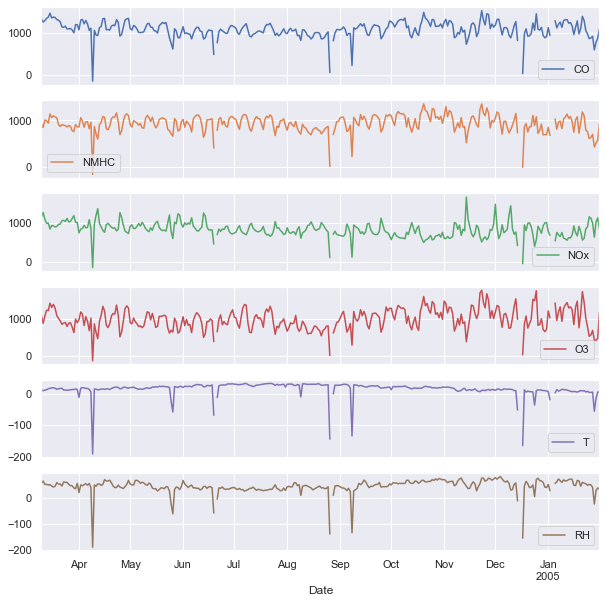

In [15]:
df_pivot.plot(subplots=True, figsize=(10, 10))
plt.show()

We note that days where the missing values do not appear to be related. For some of the days with missing values, we note that the days before and after them have some extreme values, such as extreme spikes.

One possible hypothesis is that the spikes indicate some problem with the sensor used, and thus, the sensors had to be sent for repairs, causing data to be unavailable in the meantime. This would indicate why all the sensors had missing datas on those days.

#### What should be done about missing values?

Based on our hypothesis, if the missing values are due to problems with the sensors that were detected, it may not be a good idea to immediately fill the missing values with the previous value, as it may be an outlier value.

Possible methods:
- Front fill, but mark and deal with outliers first

### Distribution of Data

#### What does the distribution of our data look like, and what does it say about the data?

In [16]:
df_pivot.describe()

Gas             CO         NMHC          NOx           O3           T  \
count   322.000000   322.000000   322.000000   322.000000  322.000000   
mean   1074.034862   932.706457   831.478477   997.677396   15.578425   
std     192.346012   184.942814   200.428180   287.769529   23.412864   
min    -142.666667  -153.458333  -155.583333  -143.697917 -191.164583   
25%     981.338542   839.421875   712.370660   809.098958   12.627083   
50%    1084.482639   948.649306   826.208333  1005.692708   18.993750   
75%    1188.539062  1061.109375   944.387153  1183.658854   25.714149   
max    1513.208333  1355.104167  1678.687500  1795.291667   32.997917   

Gas            RH  
count  322.000000  
mean    44.343425  
std     28.487081  
min   -188.839583  
25%     37.101042  
50%     46.452083  
75%     58.028386  
max     81.104167

- The mean temperature recorded is 15.57 Degrees Celcius, but the min temperature -191.164 degrees celcius. This appears to be an extreme outlier.
- The median temperature is higher than the mean temperature, suggesting a negatively skewed distribution.
- The temperatures seen are mostly consistent with the [climate of Italy](https://en.wikipedia.org/wiki/Climate_of_Italy). This suggests that the temperatures with extreme negative values are actually outliers (possibly sensor miscalibrations), and not the result of extreme cooling in the sensor device.
- The mean relative humidity is 44.34%, which is lower than the median relative humidity. This might suggest a negatively skewed distribution of the data.
- If relative humidity is in percentage, having a negative percentage relative humidity does not make sense. Consider that relative humidity is the **ratio of how much water vapour is in the air and how much water vapor the air could possibly contain at a given temperature**; How is it possible then that it is negative? Logically this must be an error (again, possibly a result of faulty sensors), and any negative values for Relative Humidity should be removed.
- Furthermore, according to the researchers who collected the data, the sensors used are only rated for a temperature of -20 to 50 degrees celcius, and a relative humidity of 10% to 90%. Hence, it is safe to consider any values out of this range as being inaccurate anyways.

![sensor specifications](sensor_specifications.png)

- In our data, we see that there are negative values for each gas as their min estimated concentration
- Recall that for the metal oxide sensors used to collect this data, we get these readings by measuring the change in resistance of the metal oxide material due to a chemical reaction between the metal oxide and the gas and using it to estimate the concentration of pollutants. Thus the "value" attribute in our data is supposed to be an estimated concentration in $\mu/m^3$ (for Nitrogen Oxides and Ozone), or $mg/m^3$ (for Carbon Monoxide)
- As such, a negative concentration does not make any sense. Given that the sensor is only giving a rough estimate of the concentration, it is highly possible that these negative values came about due to sensor errors. 
- The mean values are similar to their median, suggesting that the distribution is not highly skewed; The only outliers come from the negative values.
- Since the values are technically in different units, we may also want to perform scaling of our data.

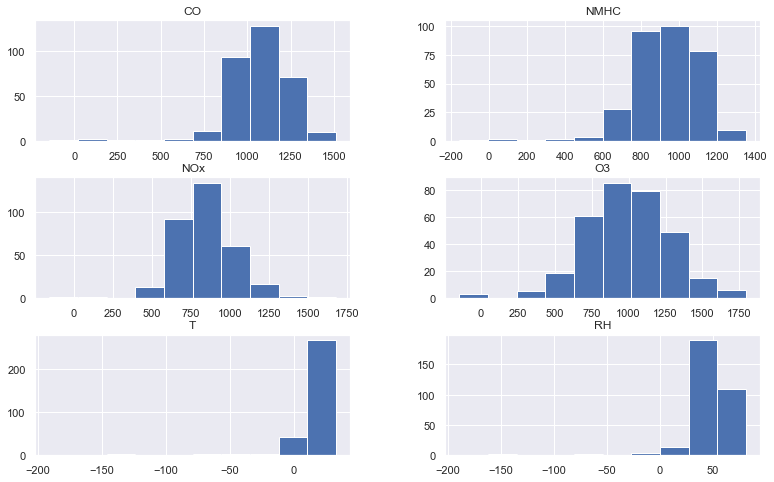

In [17]:
df_pivot.hist()
plt.show()

- We observe that the distribution of Temperature and Relative Humidity is negatively skewed, due to the outlier values
- The distribution of NOx and O3 appear to be more symmetrical
- Distribution of CO and NMHC is more negatively skewed, due to there being some outlier values.

### Outlier Analysis

From our previous analysis, we noted the presense of outliers in all numerical features. We had already come to a few conclusions based on our background research:
- These values are unnatural, and are impossible occurances in real life:
    - The freezing outlier temps are too cold for Italy's, and even too cold for the Artic
    - It is impossible for relative humidity to be negative
    - The sensors used to collect the data, are not rated for these extreme outlier temperatures/humdity
    - A negative concentration (which is what the sensors are trying to estimate), is also ridiculous. 
- Thus, we hypothesise that these come as a result of sensor calibration errors, resulting in a wrong sensor reading.

To test this hypothesis, we want to answer a few questions:
1. How many of these extreme outliers are there?
2. When do these outliers happen? Do they happen indepedently, or is there some pattern to the outlier data?

For this, we will use Tukey's Fences to denote any outliers. Recall that by this criterion, an outlier is any data that founds outside the range $[Q_1 - k(Q_3 - Q_1), Q_3 + k(Q_3 - Q_1)]$. We use Tukey's Fences, as this method is applicable to skewed data since it makes no distributional assumptions and it does not depend on a mean or standard 
deviation. In this case, we will look at the extreme outliers, setting $k=3$. We will also mark negative RH and Value as outliers, since in the context here, they are definitely wrong.

We also need to take note that for time series data, we cannot use future information to detect past outliers. Hence, we will detect outliers on a rolling basis.

In [18]:
df_outliers = df_pivot.copy(deep=True)

In [19]:
def mark_outliers(df, col, k=1.5, window=7):
    df_col = df[col].rolling(window)
    upper_quartile = df_col.quantile(.75)
    lower_quartile = df_col.quantile(.25)
    interquartille_range = upper_quartile - lower_quartile
    upper_fence = upper_quartile + (k * interquartille_range)
    lower_fence = lower_quartile - (k * interquartille_range)
    outliers = ~(df[col].between(lower_fence, upper_fence))
    return outliers

Our current outlier detection method also may miss out certain anomalies.

We want to ensure that any 'impossible' values are marked as outliers. These are values which could not possibly be 0, or are actually out of the operating range for the sensor, and thus the result may not be reliable.

In [20]:
additional_outlier_rules = {
        col : df_outliers[col] < 0 for col in ('CO', 'NMHC', 'NOx', 'O3')
} | {
    "T" : (df_outliers['T'] < -20) | (df_outliers['T'] > 50),
    "RH" : (df_outliers['RH'] < 10) | (df_outliers['RH'] > 90)
}

In [21]:
for col in df_outliers.columns:
    outliers = mark_outliers(df_outliers, col, k=3, window=7) # 1 Week Window
    df_outliers[f'Outlier ({col})'] = (outliers) | (additional_outlier_rules[col])
    

In [22]:
df_outliers[filter(lambda x : x.startswith('Outlier'),df_outliers.columns)].any(axis=1).sum()

72

In [23]:
df_outliers[filter(lambda x : x.startswith('Outlier'),df_outliers.columns)].sum()

Gas
Outlier (CO)      43
Outlier (NMHC)    42
Outlier (NOx)     49
Outlier (O3)      41
Outlier (T)       57
Outlier (RH)      51
dtype: int64

There are 72 rows with at least one outlier in total. Since there are at least >40 outliers for each column, it suggests that most days with outliers have more than one attribute with an outlier.

#### Where are the outliers in the data?

In [24]:
def plot_outlier(df, col_name, ax):
    outliers = df_outliers[df_outliers[f'Outlier ({col_name})'] == True]
    print(f"Number of Outliers for {col}:", len(outliers))
    df_outliers.plot(y=col_name, title=f"Outlier Plot of {col_name}", ax = ax)
    ax.scatter(x=outliers.index, y=outliers[col_name], color='r')

Number of Outliers for CO: 43
Number of Outliers for NMHC: 42
Number of Outliers for NOx: 49
Number of Outliers for O3: 41
Number of Outliers for T: 57
Number of Outliers for RH: 51


C:\Users\tienc\AppData\Local\Temp/ipykernel_9124/3075534334.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


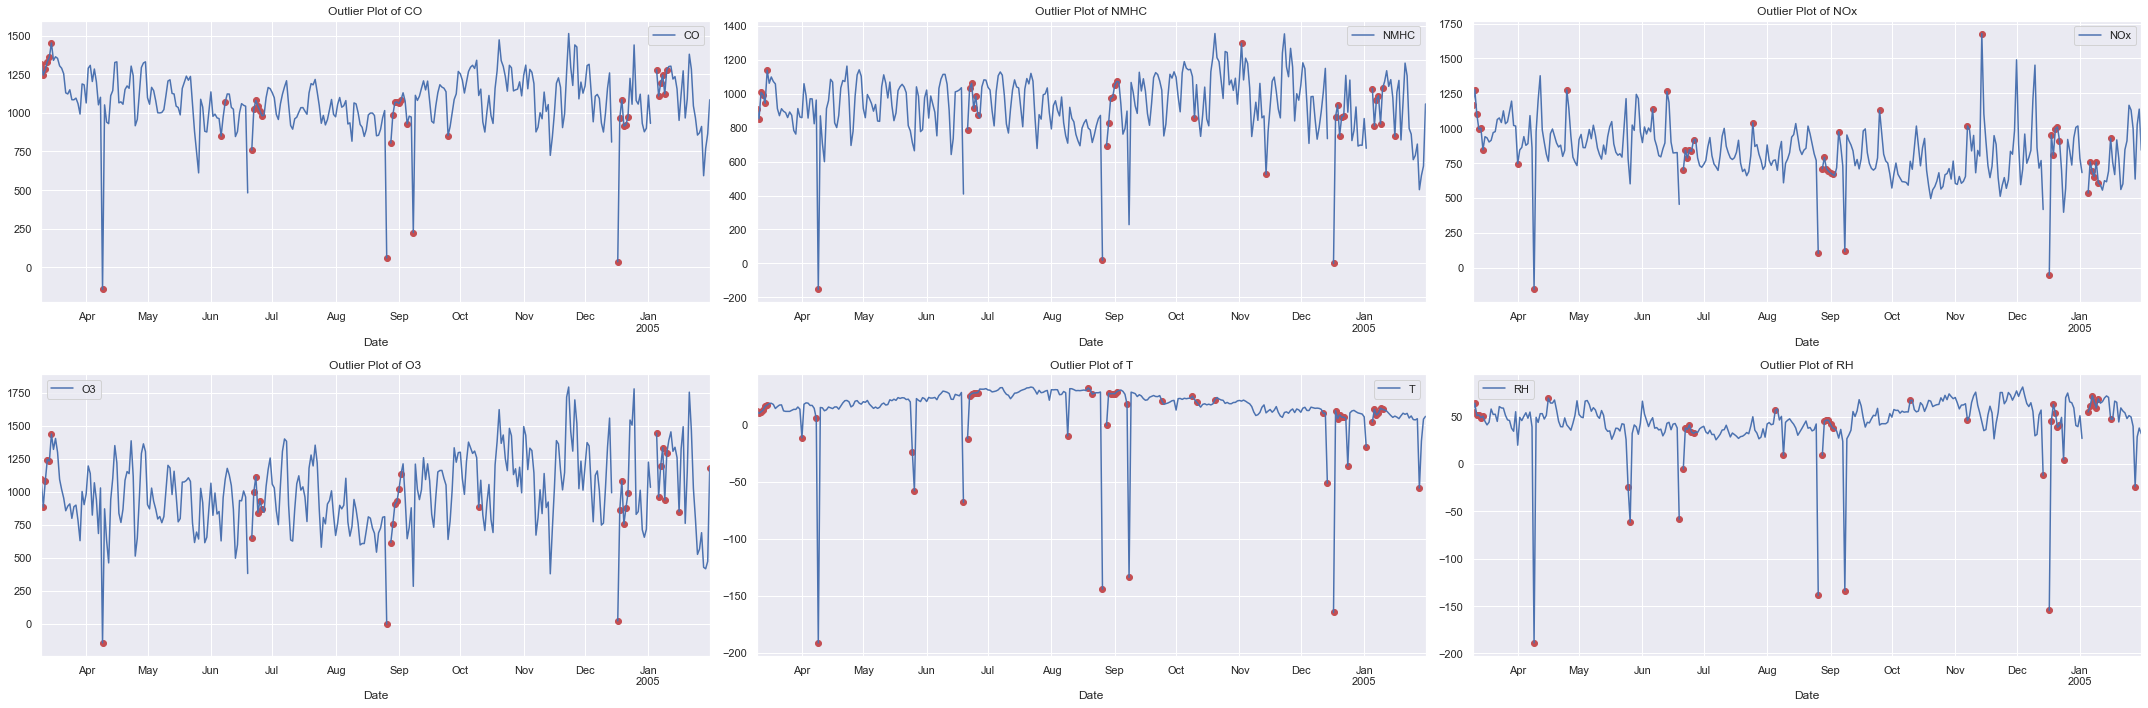

In [25]:
fig, axes = plt.subplots(2, 3, figsize=(30, 10), tight_layout=True)

for ax, col in zip(axes.ravel(), df_pivot.columns):
    plot_outlier(df_outliers, col, ax)

fig.show()

- We note that the detected outliers appear to happen at similar points in time to outliers in other features

#### What should be done about outliers?

According to [research](https://iopscience.iop.org/article/10.1088/1757-899X/864/1/012152/pdf), when there are changes in the temperature and relative humidity, it causes a change in the resistance of the sensor, thus causing the readings to drift. This suggest that outside of the operating range of the sensors used (-20 to 50 degrees in Temp, and 10-90% relative humidity), the readings of the sensor would be less accurate. 

There are a few approaches we can take here:
- Ignore the outliers. But this is likely a bad idea, as at the very least, the outlier temperature and relative humidity are definitely wrong.
- Mark the outlier value, and  
    - Impute with the previous value
    - Impute with a rolling mean

For a start, we choose to ignore the extreme outliers, only cleaning the 'impossible' outliers first. Later on we will see what happens when extreme outliers are cleaned.

In [26]:
df_outliers.sum(axis=0)

Gas
CO                345839.225691
NMHC              300331.479173
NOx               267736.069443
O3                321252.121517
T                   5016.252777
RH                 14278.582988
Outlier (CO)          43.000000
Outlier (NMHC)        42.000000
Outlier (NOx)         49.000000
Outlier (O3)          41.000000
Outlier (T)           57.000000
Outlier (RH)          51.000000
dtype: float64

In [27]:
df_basic_clean = df_pivot.copy(deep=True)
for col in df_basic_clean.columns:
    outliers = additional_outlier_rules[col]
    df_basic_clean.loc[outliers, col] = np.nan
print("Before:", df_basic_clean.isna().sum())
df_basic_clean = df_basic_clean.ffill().bfill()
print("After:", df_basic_clean.isna().sum())


Before: Gas
CO       7
NMHC     8
NOx      8
O3       8
T       16
RH      19
dtype: int64
After: Gas
CO      0
NMHC    0
NOx     0
O3      0
T       0
RH      0
dtype: int64


### Correlation
#### What are the relationships between the various variables?

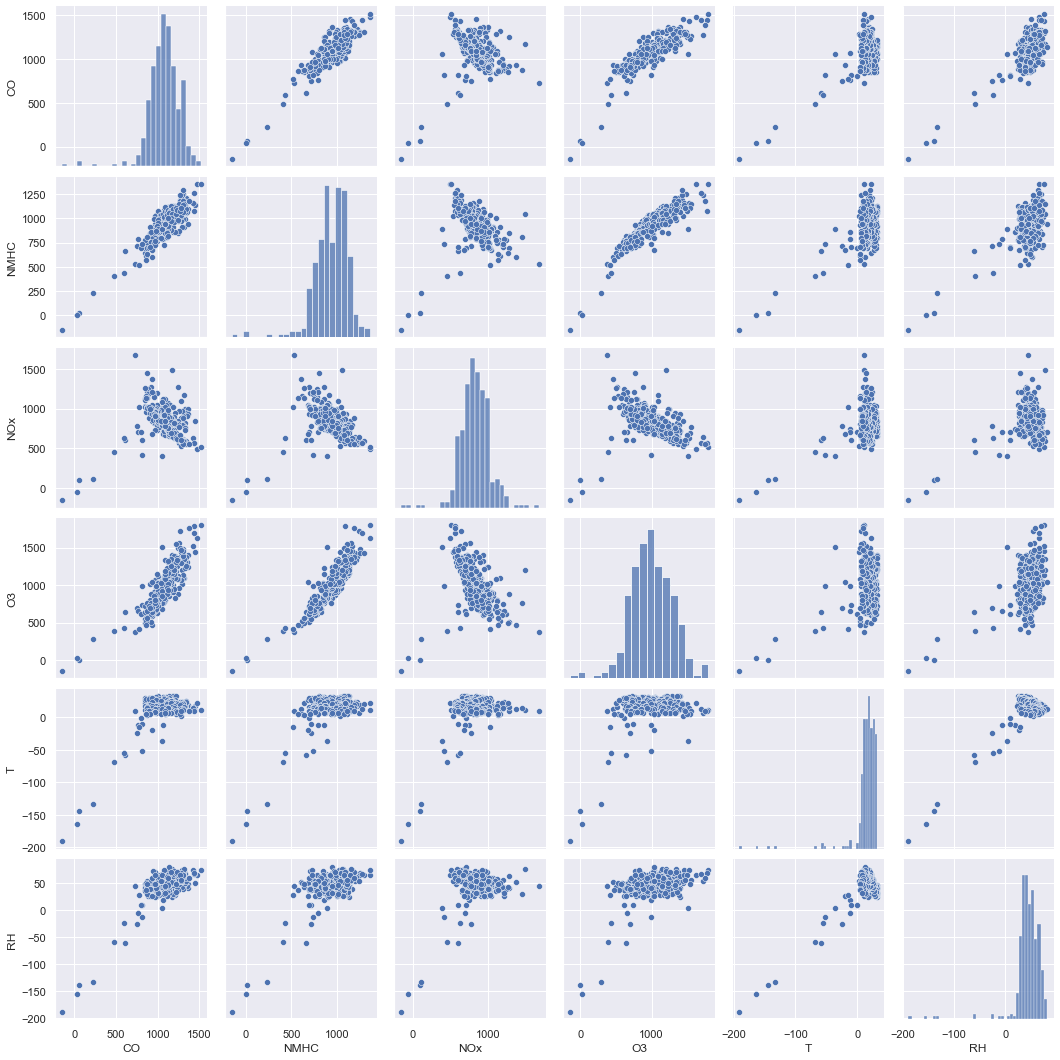

In [28]:
sns.pairplot(df_pivot)

We see that before we cleaned the data, there were many outliers, which do not follow the trend of the data.

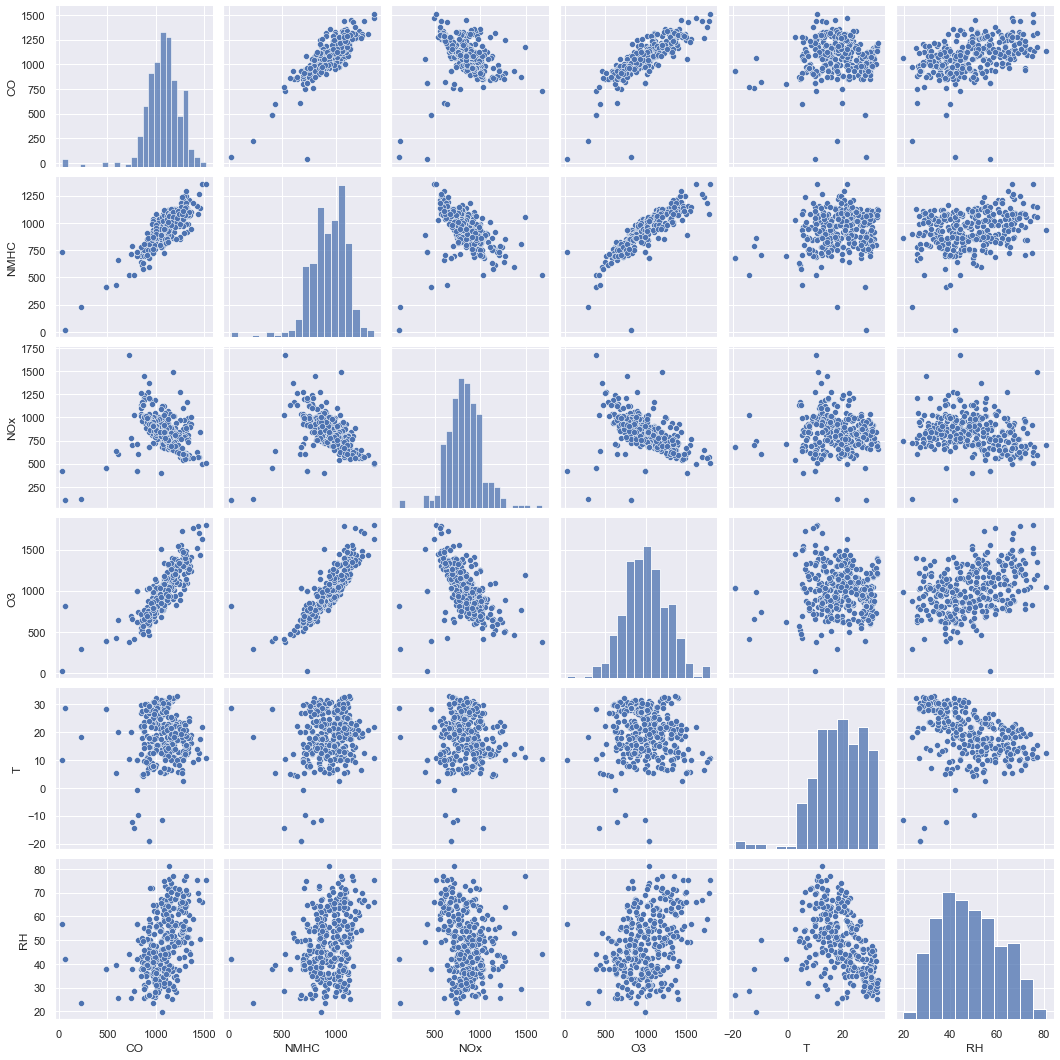

In [29]:
sns.pairplot(df_basic_clean)

To avoid recording spurious correlation (false correlation due to within-series dependence), we will instead calculate correlation based off the percentage change (the differenced data).

To calculate correlation, we use Pearson's correlation coefficient.

<AxesSubplot:xlabel='Gas', ylabel='Gas'>

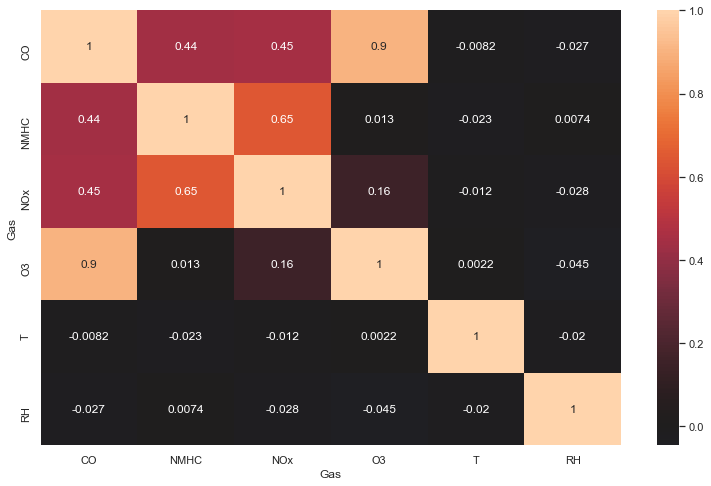

In [30]:
sns.heatmap(df_basic_clean.pct_change().corr(), annot=True, center=0)

- We observe that the change in CO levels is highly correlated with the change in Ozone (r=0.9) and NMHC (r=0.44) levels 

### Time Series

#### What can be said about the trend and seasonality of the data?

To have a clearer understanding of our data, we want to decompose the time series into it's components, which are: the Seasonal Component ($S_t$), the Trend-Cycle component ($T_t$), and the remainder components ($R_t$)

There are two ways which we can decompose our data, additively ($y_t = S_t + T_t + R_t$), or multiplicatively ($y_t = S_t \times T_t \times R_t$). Given that for most our our time series data (except that of Relative Humidity), the variance does not change as the mean changes, an additive model for decomposition makes the most sense. 

To decompose the data, we will use STL decomposition, due to it's advantages over classical decomposition methods. (it allows for the seasonal component to change over time, and is robust to outliers, which is important given that we showed earlier that unusual observations exist in the data). 

##### Temperature (T)

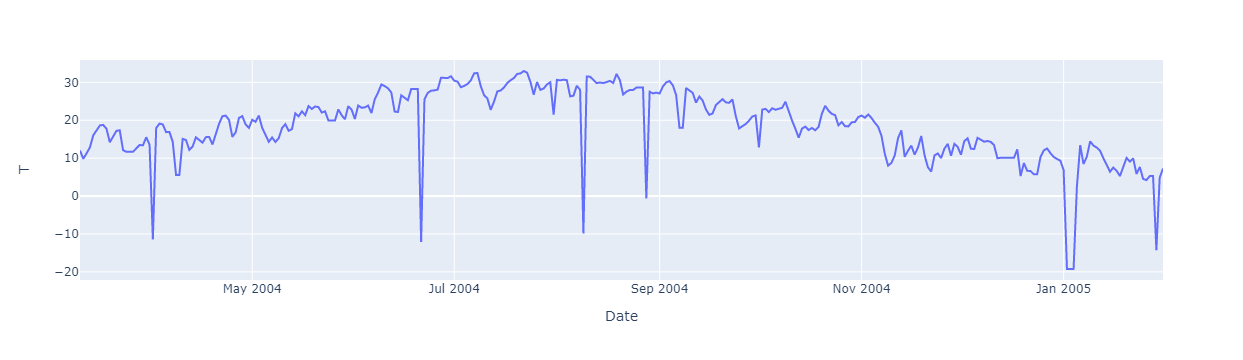

In [31]:
px.line(data_frame=df_basic_clean, y='T')

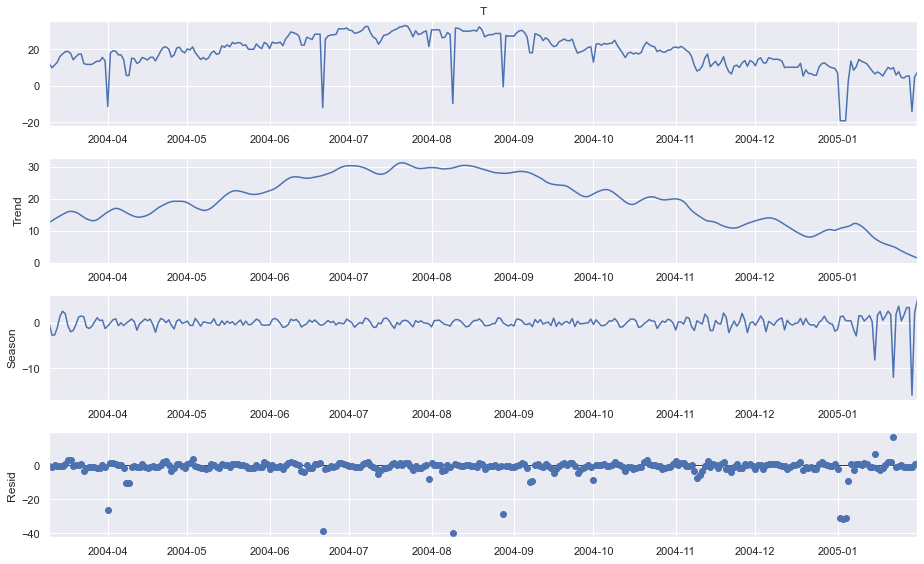

In [32]:
res = STL(df_basic_clean['T'], robust=True).fit()
res.plot()
plt.show()

- There is a upward non-linear trend in temperature from April to August, before the trend changes direction to become downwards. 
- The seasonality in the data does not appear to be very strong, and seems inconsistent.
- The temperature peaked between the months of June and September, where temperature was between 20 to 30 degrees celcius. The peak temperatures occured in July, where some days were above 30 degrees.
- The temperature is the lowest during the start of the year and near the end of the year, which are during the Winter season.
- The mean temperature does not remain constant through the year, but the variance appears to remain constant through the year.

##### Relative Humidity (RH)

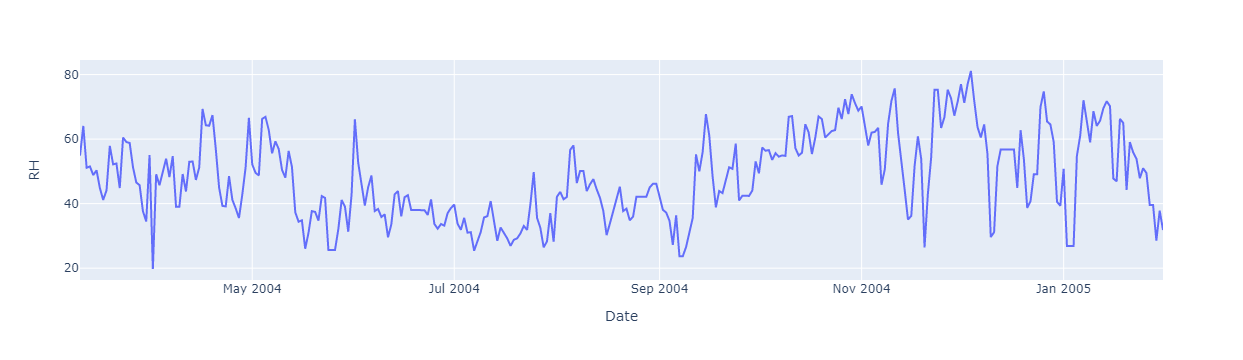

In [33]:
px.line(data_frame=df_basic_clean, y='RH')

We note that the variance of the relative humidity appears to increase when the relative humidity increases. This suggests a multiplicative decomposition of the data is appropriate. Since STL decomposition is only additive, we will use classical decomposition methods for this feature.

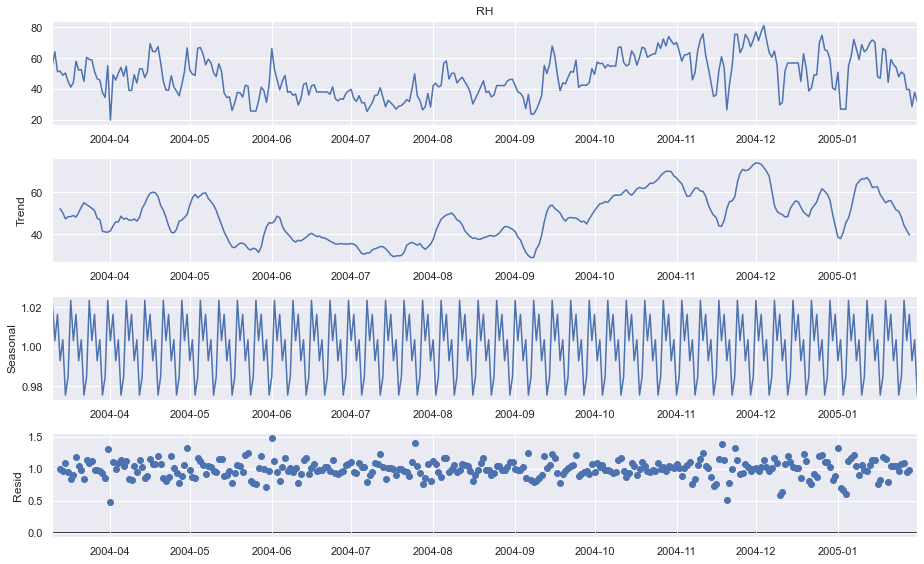

In [34]:
res = seasonal_decompose(df_basic_clean['RH'], 'multiplicative')
res.plot()
plt.show()

- There is a downward trend in relative humidity from April to August, before the trend changes direction to become downwards. The trend appears to be non-linear.
- It is clear that there is strong seasonality in the data, as even the trend appears to follow the seasonality after it is decomposed.
- The mean and variance of the relative humidity do not appear to be constant throughout the year, as the mean and variance of relative humidity appears to be lower during the months of June to September.
- This period of low humidity corresponds to a period of the highest temperatures of the year. This makes sense as **relative humidity is inversely proportional to temperature**
- Thus, the peak period of high relative humidity is also during the coldest parts of the year, during the end and the start of the year.

##### Carbon Monoxide (CO)

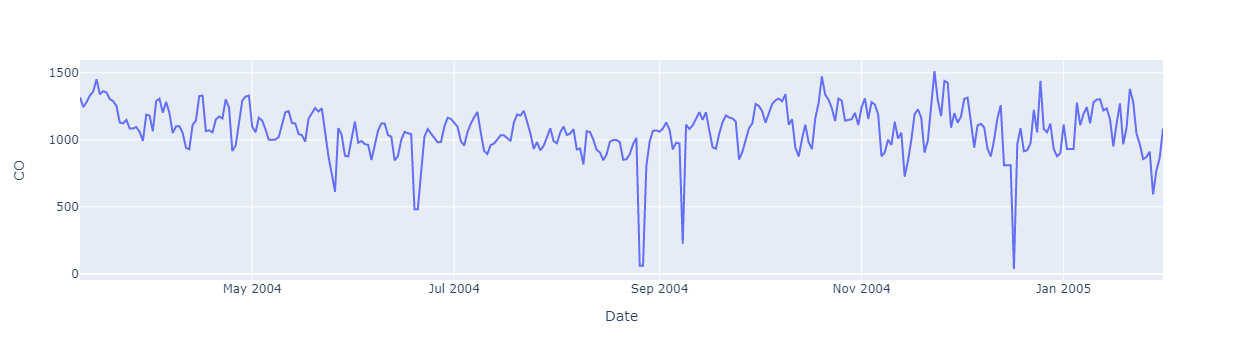

In [35]:
px.line(data_frame=df_basic_clean, y='CO')

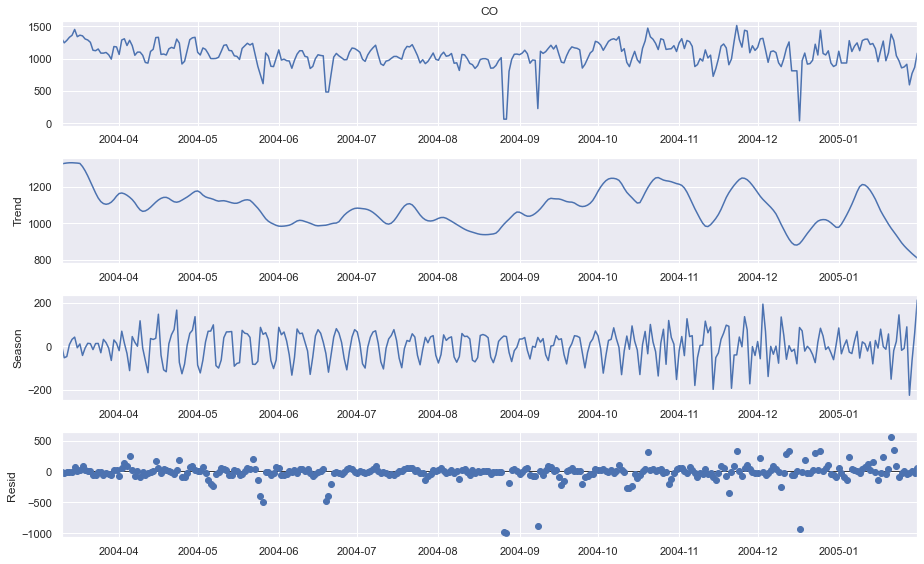

In [36]:
res = STL(df_basic_clean['CO'], robust=True).fit()
res.plot()
plt.show()

- The concentration of CO has a downward non-linear trend from April 2004 to August 2004, before changing direction to a upward trend from September 2004 to January 2005 (but the trend becomes weaker nearing the end of the year)
- There is a seasonality in the data, that appears to repeat every week, where the concentration rises and falls. This could correspond to increased edmissions during the weekdays compared to weekends.
- The concentration of Carbon Monoxide appears to have a constant mean and variance, suggesting that it is stationary.
- On Weekends, it seems that CO concentration is lower, but this requires further statistical testing to verify. This could potentially be due to human sources of CO like vehicle emissions being lower when people are not working, and thus commuting less. 

##### Non-methane Hydrocarbons (NMHC)

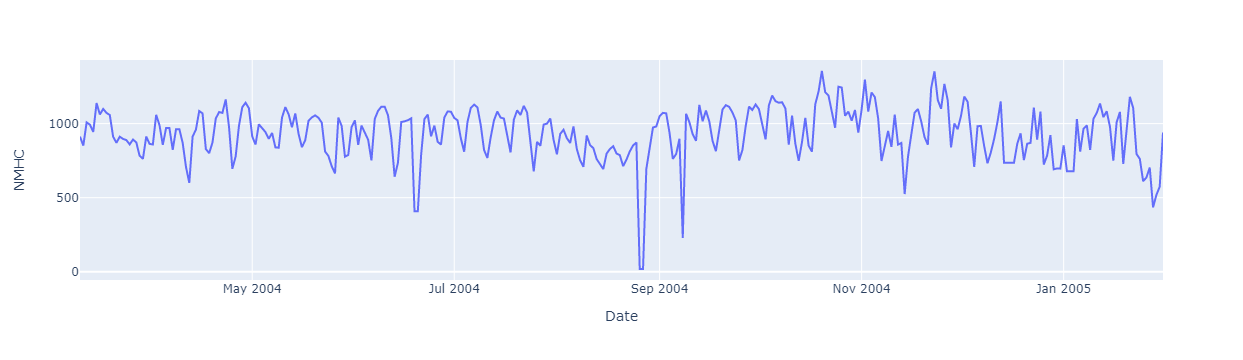

In [37]:
px.line(data_frame=df_basic_clean, y='NMHC')

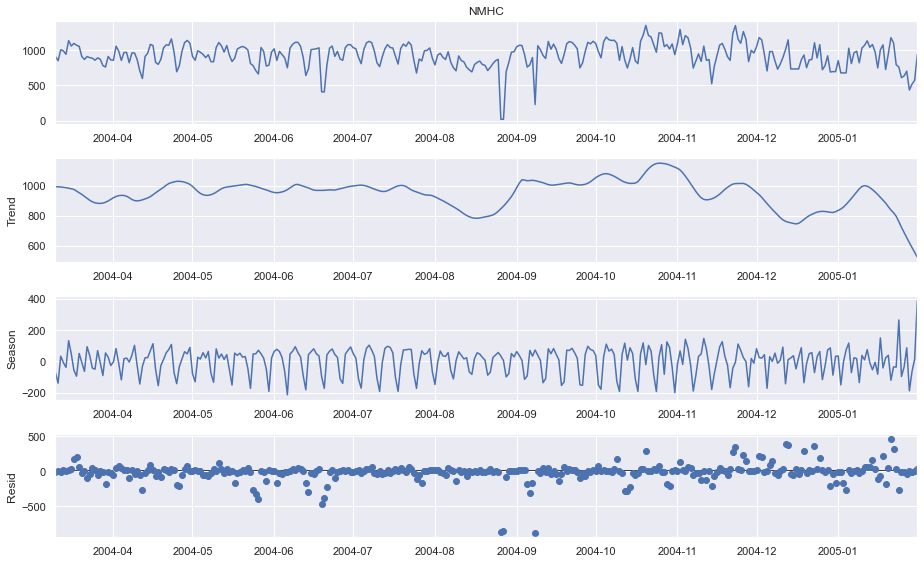

In [38]:
res = STL(df_basic_clean['NMHC'], robust=True).fit()
res.plot()
plt.show()

- The trend for NMHC is very weak, and does not appear to change significantly
- The seasonality is much stronger, with there being a cycle that seemingly corresponds to each week.
- Similarily to that for CO, emissions of NMHC appear to be much lower during the weekends.
- One reason for this is that NMHC is also emitted via human sources like vehicle exhaust, chemical manufacturing and energy production, which might decrease during the weekend, when there is less human activity.

##### Nitrogen Oxides

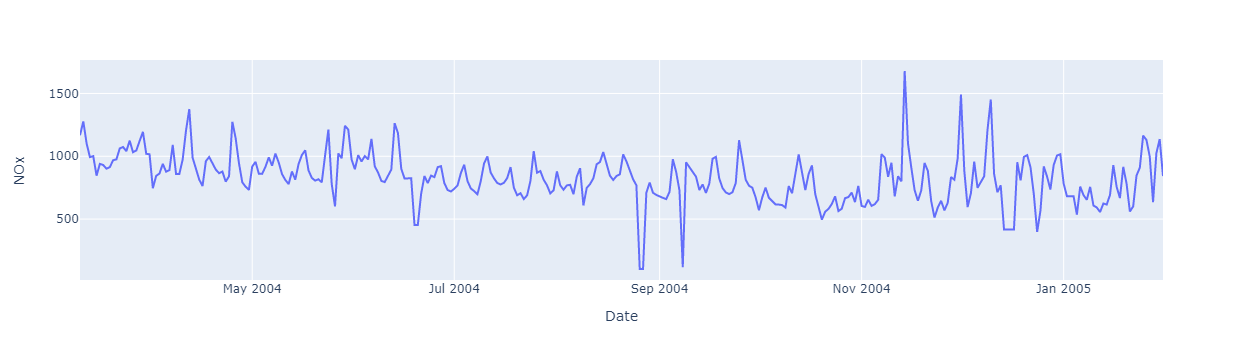

In [39]:
px.line(data_frame=df_basic_clean, y='NOx')

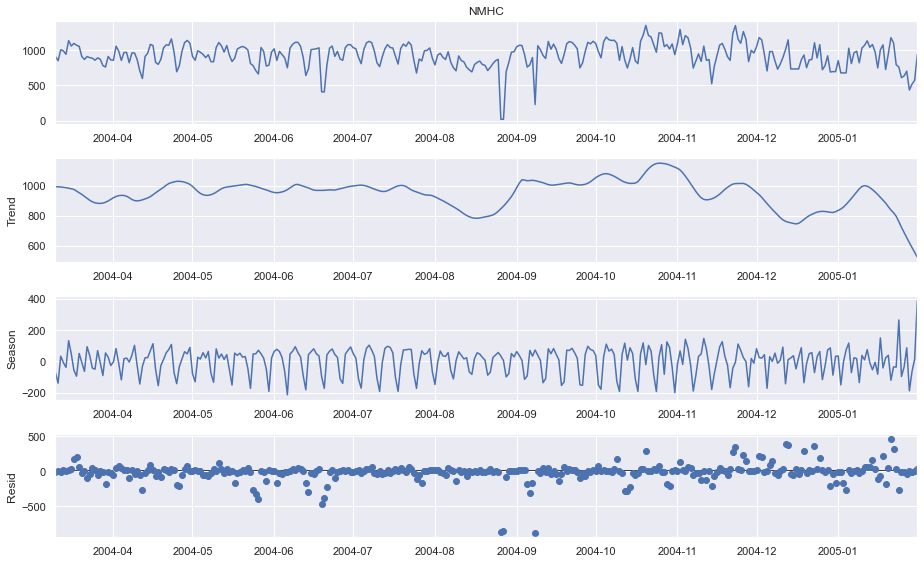

In [40]:
res = STL(df_basic_clean['NMHC'], robust=True).fit()
res.plot()
plt.show()

- For NOx concentrations, the time series does not appear to be stationary, as the mean and variance vary slightly
- There appears to be a small downward trend in the data
- There is a non-linear downward trend between April 2004 to November 2004, before changing directions to an upward trend from December 2004 to January 2001. This suggests that emissions of Nitrogen Oxides have been decreasing over time.
- This is corroborated by referencing the emission trend of Nitrogen oxides in Italy, where there has been a sharp decrease in NOx emissions fromm 2000 to 2018. [Source](https://www.statista.com/statistics/809161/nitrogen-oxides-nox-emission-trend-in-italy/)
- According to the European Environment Agency, this is due to the installation of catalysts to vehicles during this period as per new EU standards, resulting in lower NOx emissions from vehicles. (47% of the reduction in NOx emissions from 1990 and 2011 come from vehicle emissions)  [Source](https://www.eea.europa.eu/data-and-maps/indicators/eea-32-nitrogen-oxides-nox-emissions-1/assessment.2010-08-19.0140149032-3#:~:text=The%20sectors%20responsible%20for%20the,distribution%27%20(contributing%2027%25).)

##### Ozone (O3)

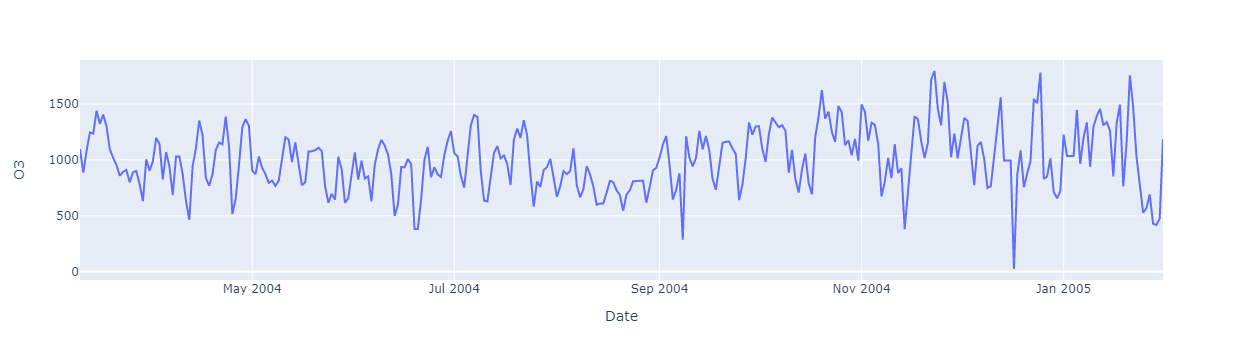

In [41]:
px.line(data_frame=df_basic_clean, y='O3')

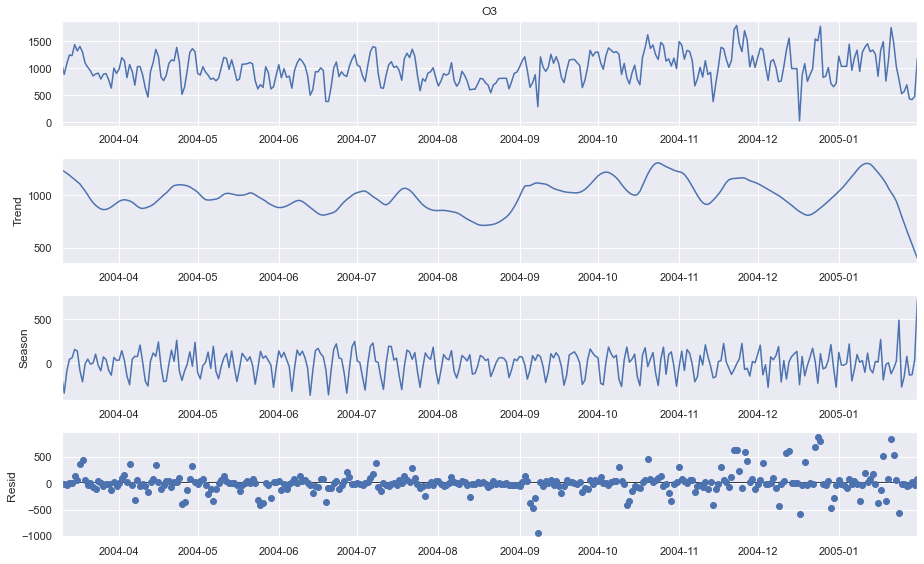

In [42]:
res = STL(df_basic_clean['O3'], robust=True).fit()
res.plot()
plt.show()

- The concentration of Ozone has a downward non-linear trend from April 2004 to August 2004, before changing direction to a upward trend from September 2004 to January 2005.
- The time series appears to have a constant mean, but there is some variation in the variance, such as during the start of the year.
- According to the US Environmental Protection Agency,ground level ozone, is not emitted directly into the air, but is created by chemical reactions between oxides of nitrogen (NOx) and volatile organic compounds (VOC). This happens when pollutants emitted by cars, power plants, industrial boilers, refineries, chemical plants, and other sources chemically react in the presence of sunlight.
- This may explain why the highest levels of Ozone are also the periods of time in which NOx levels are the highest (November to January)
- Strangely, this period is also very cold, and low temperatures should cause levels of Ozone to become lower. Hence it is likely that the increase in Ozone is due to the higher levels of NOx

##### Strength of Trend and Seasonality
It is useful for us to know how strong trend and seasonality are in our time series data, for later model selection and improvement.

[For strongly trended data, the seasonally adjusted data should have much more variation than the remainder component.](https://otexts.com/fpp2/seasonal-strength.html) Therefore $Var(R_t)/Var(T_t+R_t)$ should be relatively small. But for data with little or no trend, the two variances should be approximately the same. So the strength of trend is defined as
$$
F_t = \max (0, 1 - \frac{Var(R_t)}{Var(T_t + R_t)})
$$

Similarily, we define the strength of seasonality as
$$

F_s = \max (0, 1 - \frac{Var(R_t)}{Var(S_t + R_t)})

$$

In [43]:
trends, seasonality, residuals = [], [], []
for feature in df_basic_clean.columns:
    decomposition = STL(df_basic_clean[feature], robust=True).fit()
    trends.append(decomposition.trend)
    seasonality.append(decomposition.seasonal)
    residuals.append(decomposition.resid)

decompose_df = pd.DataFrame({
    "Var_Trend" : [trend.var() for trend in trends],
    "Var_Seasonality + Residual" : [(season + resid).var() for season, resid in zip(seasonality, residuals)],
    "Var_Trend + Residual" : [(trend + resid).var() for trend, resid in zip(trends, residuals)],
    "Var_Residuals":  [resid.var() for resid in residuals],
}, index = df_basic_clean.columns)
decompose_df['Trend Strength'] = decompose_df.apply(lambda feature : max(0, 1 - (feature['Var_Residuals'] / feature['Var_Trend + Residual'])), axis = 1)
decompose_df['Seasonal Strength'] = decompose_df.apply(lambda feature : max(0, 1 - (feature['Var_Residuals'] / feature['Var_Seasonality + Residual'])), axis = 1)

decompose_df

Var_Trend  Var_Seasonality + Residual  Var_Trend + Residual  \
Gas                                                                    
CO    10102.413936                23584.996228          35158.044584   
NMHC   9388.893215                23747.347272          26748.766489   
NOx   11085.555527                27198.962947          34876.283974   
O3    22094.398174                52172.255083          65342.591996   
T        56.985568                   27.794144             82.386004   
RH      118.949552                   66.441728            174.260273   

      Var_Residuals  Trend Strength  Seasonal Strength  
Gas                                                     
CO     21936.446830        0.376062           0.069898  
NMHC   18336.321271        0.314498           0.227858  
NOx    24251.980823        0.304628           0.108349  
O3     39294.674300        0.398636           0.246828  
T         27.205173        0.669784           0.021190  
RH        63.499944        0.635603           0.044276

- We see that out of all of the gases, Ozone has the strongest trend and Seasonality, whilst Carbon Monoxide has a strong trend but weak seasonality
- **No seasonal differencing** is recommended, as the strength of seasonality < 0.64 [Source: Forecasting Principles and Practices](https://otexts.com/fpp3/stationarity.html#unit-root-tests)

## Data Pre-processing
Now, we will proceed to process our data. This will involve transforming our data, and dealing with missing values and outliers.

In [44]:
def DataPreprocess(dataset, train = True, impute=True, remove_outliers=True, advanced_outlier_removal = False):
    missing_days = pd.isnull(dataset).any(axis=1)
    basic_outlier_rules = {
    "T" : (dataset['T'] < -20) | (dataset['T'] > 50),
    "RH" : (dataset['RH'] < 10) | (dataset['RH'] > 90)
}
    if remove_outliers:
        dataset.loc[basic_outlier_rules['T'], 'T'] = np.nan
        dataset.loc[basic_outlier_rules['RH'], 'RH'] = np.nan
        if train:
            additional_outlier_rules = {
            col : dataset[col] < 0 for col in ('CO', 'NMHC', 'NOx', 'O3')
    } 
            for col in dataset.columns:
                if advanced_outlier_removal:
                    outliers = mark_outliers(dataset, col, k=3, window=7)
                    is_outlier = outliers
                    dataset.loc[is_outlier, col] = np.nan
                    print("No of Outliers (Advanced Rules) for", col, np.sum(is_outlier))
                else:
                    if col in additional_outlier_rules:
                        is_outlier = additional_outlier_rules[col]
                        dataset.loc[is_outlier, col] = np.nan
                        print("No of Outliers (Basic Filtering) for", col, np.sum(is_outlier))
                        dataset.loc[is_outlier, col] = np.nan
    if impute:
        dataset = dataset.ffill().bfill()
    if not train:
        return dataset, missing_days
    else:
        return dataset

            


In [45]:
df_pivot.describe()

Gas             CO         NMHC          NOx           O3           T  \
count   322.000000   322.000000   322.000000   322.000000  322.000000   
mean   1074.034862   932.706457   831.478477   997.677396   15.578425   
std     192.346012   184.942814   200.428180   287.769529   23.412864   
min    -142.666667  -153.458333  -155.583333  -143.697917 -191.164583   
25%     981.338542   839.421875   712.370660   809.098958   12.627083   
50%    1084.482639   948.649306   826.208333  1005.692708   18.993750   
75%    1188.539062  1061.109375   944.387153  1183.658854   25.714149   
max    1513.208333  1355.104167  1678.687500  1795.291667   32.997917   

Gas            RH  
count  322.000000  
mean    44.343425  
std     28.487081  
min   -188.839583  
25%     37.101042  
50%     46.452083  
75%     58.028386  
max     81.104167

In [46]:
train = DataPreprocess(df_pivot, train=True, remove_outliers=True, impute=True)
train

No of Outliers (Basic Filtering) for CO 1
No of Outliers (Basic Filtering) for NMHC 2
No of Outliers (Basic Filtering) for NOx 2
No of Outliers (Basic Filtering) for O3 2


Gas                  CO         NMHC          NOx           O3          T  \
Date                                                                        
2004-03-10  1316.500000   912.250000  1167.250000  1096.041667  12.020833   
2004-03-11  1244.062500   851.802083  1277.187500   885.031250   9.833333   
2004-03-12  1281.562500  1008.229167  1101.718750  1084.218750  11.292708   
2004-03-13  1330.555556   992.822917   993.159722  1245.781250  12.866319   
2004-03-14  1360.927083   943.854167  1001.104167  1234.177083  16.016667   
...                 ...          ...          ...          ...        ...   
2005-01-27   911.777778   703.312500   997.059028   691.475694   5.267708   
2005-01-28   592.864583   434.350694   635.225694   429.375000   5.267708   
2005-01-29   769.625000   518.093750  1024.666667   418.072917 -14.272917   
2005-01-30   864.642361   573.684028  1136.718750   474.392361   4.848611   
2005-01-31  1084.500000   939.791667   842.177083  1184.166667   7.273958   

Gas                RH  
Date                   
2004-03-10  54.883334  
2004-03-11  64.069791  
2004-03-12  51.107292  
2004-03-13  51.530903  
2004-03-14  48.843750  
...               ...  
2005-01-27  39.614930  
2005-01-28  39.614930  
2005-01-29  28.563542  
2005-01-30  37.832986  
2005-01-31  31.809375  

[328 rows x 6 columns]

## Modelling

### Evaluation Methodology
To evaluate our models, we will make use of:
- Corrected AIC
- Time Series Cross Validated Root Mean Square Error

### Utility Functions

In [47]:
gases = ['CO', 'NMHC', 'NOx', 'O3']

In [48]:
def adf_test(series, significance_level = 0.05):
    print(f"Test for Stationarity\nSignificance Level: {significance_level}\nH0: There is a unit root (non-stationary time series)\nH1: There is no unit root (stationary time series)")
    test_statistic, pvalue, usedlag, *_ = adfuller(series)
    print(f"P-value: {pvalue:.3f}")
    print(f"Used Lag: {usedlag}")
    if pvalue < significance_level:
        print("Reject H0. There is evidence that the time series is stationary.")
    else:
        print("Fail to reject H0. There is insufficient evidence that the time series is stationary.")
    return test_statistic, pvalue, usedlag

In [49]:
def kpss_test(series, significance_level = 0.05):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        print(f"Test for Stationarity\nSignificance Level: {significance_level}\nH0: Process is trend stationary\nH1: There is a unit root (non-stationary)")
        test_statistic, pvalue, usedlag, *_ = kpss(series, regression="c", nlags="auto")
        print(f"P-value: {pvalue:.3f}")
        print(f"Used Lag: {usedlag}")
        if pvalue < significance_level:
            print("Reject H0. There is evidence that the time series is not stationary.")
        else:
            print("Fail to reject H0. There is insufficient evidence that the time series is not stationary.")
        return test_statistic, pvalue, usedlag

In [50]:
def multi_step_predict(model, existing_data, start, end, model_params = {}, test_exog = None):
    """
    Does multi-step time series prediction, where the model is refitted for every new prediction.
    """
    forecasts = []
    data = existing_data
    for date in pd.date_range(start, end):
        cur_model = model(data, **model_params).fit()
        try:
            if test_exog is not None:
                current_exog = test_exog.loc[:date]
                forecast = cur_model.predict(start=date, exog=current_exog).values[0]
            else:
                forecast = cur_model.predict(start=date).values[0]
        except:
            forecast = cur_model.get_prediction(start=date).predicted_mean.values[0]
        # forecast = cur_model.forecast(steps=1)
        forecasts.append(forecast)
        data.append(pd.Series(forecast))
    return forecasts, cur_model

In [51]:
def eval_model(model, dataset, model_params = {}, cv = TimeSeriesSplit(5), refit=True):
    """
    Function to evaluate a given model. It makes an assumption that the dataset that is passed to it is already pre-processed, or that the model will process it.
    It will return:
    - the model used
    - cross-validated metrics
    - final metrics 
    """
    if 'order' in model_params:
        order = model_params['order']
    else:
        order = (0, 0, 0)
    if 'exog' in model_params:
        exog = model_params['exog']
    # Cross validate
    cv_metrics = defaultdict(list)
    for train_idx, test_idx in cv.split(dataset):
        if 'exog' in model_params:
            train_exog = exog.iloc[train_idx]
            test_exog = exog.iloc[test_idx]
            model_params['exog'] = train_exog
        else:
            train_exog = None
            test_exog = None
        train_fold = dataset.iloc[train_idx]
        test_fold = dataset.iloc[test_idx]
        res = model(train_fold, **model_params).fit()
        try:
            cv_metrics['Corrected AIC'].append(res.aicc)
        except Exception as Error:
            print(Error)
        try:
            if train_exog is not None:
                train_preds = res.predict(start=train_fold.index[0 + order[1]], end=train_fold.index[-1], exog=train_exog)
            else:
                train_preds= res.predict(start=train_fold.index[0 + order[1]], end=train_fold.index[-1])
        except:
            train_preds = res.get_prediction(start=train_fold.index[0 + order[1]], end=train_fold.index[-1], exog=train_exog).predicted_mean
        # train_preds = res.forecast(len(train_idx - order[1]))
        rmse_train = np.sqrt(mean_squared_error(train_fold[0 + order[1]:], train_preds))
        cv_metrics['Train RMSE'].append(rmse_train)
        if refit:
            test_preds, _ = multi_step_predict(model, train_fold, test_fold.index[0], test_fold.index[-1], model_params=model_params, test_exog=test_exog)
        else:
            if train_exog is not None:
                test_preds = res.predict(start=test_fold.index[0], end=test_fold.index[-1], exog=test_exog)
            else:
                test_preds = res.predict(start=test_fold.index[0], end=test_fold.index[-1])
        rmse_test = np.sqrt(mean_squared_error(test_fold, test_preds))
        cv_metrics['Test RMSE'].append(rmse_test)

    # Refit Model to Entire Training Set and Get Corrected AIC
    if 'exog' in model_params:
        model_params['exog'] = exog
    final_model = model(dataset, **model_params).fit()
    try:
        cv_metrics['Final AICc'] = [final_model.aicc] * cv.get_n_splits()
    except Exception as Error:
        print(Error)
    return final_model, cv_metrics

In [52]:
def parse_results(dataframe):
    cols = [pd.DataFrame(dataframe[col]) for col in dataframe.keys()]
    return pd.concat(cols, axis=1, keys=dataframe.keys())

In [53]:
def generate_file_name(text, extension = "pkl", location = "models", date = False):
    cur_date = pd.to_datetime("now")
    if date:
        return f"{location}/{text}_{cur_date.year}-{cur_date.month}-{cur_date.day}-{cur_date.hour}-{cur_date.minute}-{cur_date.second}.{extension}"
    else:
        return f"{location}/{text}.{extension}"

In [54]:
def overall_perf(results):
    return results.iloc[1, :].droplevel(0)['Test RMSE'].mean()

In [55]:
def record_history(model_name, cv_metrics, gas, past_history = None, save_history = True):
    if past_history is None:
        if save_history is True and path.exists("history.csv"):
            past_history = pd.read_csv("history.csv", index_col=0)
        else:
            past_history = pd.DataFrame(columns=['Model Name', 'Mean Test RMSE', 'Final AICc', 'Gas'])
    cur_result = pd.Series({
        "Model Name" : model_name,
        "Mean Test RMSE" : np.mean(cv_metrics['Test RMSE']),
        "Final AICc" : np.mean(cv_metrics['Final AICc']),
        "Gas" : gas
    })
    history = past_history.append(cur_result, ignore_index=True)
    if save_history:
        history.to_csv("history.csv")
    return history

In [119]:
def ts_plot(data, lags=31):
    gs = gridspec.GridSpec(2, 2)

    fig = plt.figure(figsize=(15, 8))
    time_plot = fig.add_subplot(gs[0, :])
    time_plot.plot(data)
    time_plot.set_title("Time Plot")
    acf_plot = fig.add_subplot(gs[1, 0])
    plot_acf(data, ax = acf_plot, lags=lags)
    pacf_plot = fig.add_subplot(gs[1, 1])
    plot_pacf(data, ax = pacf_plot, lags=lags)

    return fig

### Models

#### Exponential Smoothing

In [57]:
Exp_Smoothing_Results = defaultdict(list)
file_names = []
with warnings.catch_warnings():
    warnings.simplefilter("ignore", FutureWarning) # Silence warning about initialization of model in future versions
    for gas in tqdm(gases):
        final_model, cv_metrics = eval_model(ExponentialSmoothing, train[gas])
        Exp_Smoothing_Results[gas] = cv_metrics
        file_name = generate_file_name(f"ExpSmoothingModel-{gas}", date=False, location="models/ExpSmoothing")
        file_names.append(file_name)
        final_model.save(file_name)
        history = record_history(f"ExpSmoothingModel-{gas}", cv_metrics, gas)
results = parse_results(Exp_Smoothing_Results).describe()

100%|████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.03s/it]


##### Model Analysis

In [58]:
results.T

count         mean           std          min  \
CO   Corrected AIC    5.0  1634.406920  8.807591e+02   544.911816   
     Train RMSE       5.0   129.013784  2.290015e+01   105.269814   
     Test RMSE        5.0   211.118460  6.263658e+01   160.666371   
     Final AICc       5.0  3355.023955  5.084230e-13  3355.023955   
NMHC Corrected AIC    5.0  1661.246374  8.853042e+02   554.695639   
     Train RMSE       5.0   140.544939  2.024501e+01   114.533805   
     Test RMSE        5.0   204.222215  5.512427e+01   159.746854   
     Final AICc       5.0  3340.241747  0.000000e+00  3340.241747   
NOx  Corrected AIC    5.0  1664.981574  8.817322e+02   569.503413   
     Train RMSE       5.0   144.089998  1.566056e+01   128.999038   
     Test RMSE        5.0   210.039191  6.183899e+01   127.126280   
     Final AICc       5.0  3388.009431  5.084230e-13  3388.009431   
O3   Corrected AIC    5.0  1769.599068  9.152372e+02   622.997534   
     Train RMSE       5.0   202.978528  7.855360e+00   192.765072   
     Test RMSE        5.0   325.500094  6.256471e+01   225.112828   
     Final AICc       5.0  3608.997874  5.084230e-13  3608.997874   

                            25%          50%          75%          max  
CO   Corrected AIC  1083.112679  1565.743507  2218.770255  2759.496342  
     Train RMSE      110.310418   123.445335   152.628467   153.414887  
     Test RMSE       175.177419   176.087080   231.475796   312.185632  
     Final AICc     3355.023955  3355.023955  3355.023955  3355.023955  
NMHC Corrected AIC  1109.494178  1615.393352  2237.649829  2788.998871  
     Train RMSE      128.104470   138.874823   160.140900   161.070697  
     Test RMSE       174.968062   176.770262   213.289324   296.336574  
     Final AICc     3340.241747  3340.241747  3340.241747  3340.241747  
NOx  Corrected AIC  1115.494058  1617.703690  2216.384466  2805.822245  
     Train RMSE      130.128607   142.644875   152.585284   166.092185  
     Test RMSE       184.857751   216.974118   224.405106   296.832701  
     Final AICc     3388.009431  3388.009431  3388.009431  3388.009431  
O3   Corrected AIC  1192.509757  1751.057219  2336.677539  2944.753290  
     Train RMSE      200.560717   201.175616   206.371813   214.019423  
     Test RMSE       309.232329   348.154127   358.647281   386.353907  
     Final AICc     3608.997874  3608.997874  3608.997874  3608.997874

In [59]:
history

Mean Test RMSE   Final AICc   Gas                              Model Name
0       211.118460  3355.023955    CO                    ExpSmoothingModel-CO
1       204.222215  3340.241747  NMHC                  ExpSmoothingModel-NMHC
2       210.039191  3388.009431   NOx                   ExpSmoothingModel-NOx
3       325.500094  3608.997874    O3                    ExpSmoothingModel-O3
4       191.314699  4361.402101    CO     SARIMAX-(0, 0, 2)-(1, 0, 0, 7)-CO-c
5       179.827334  4293.559224  NMHC   SARIMAX-(0, 0, 0)-(2, 0, 2, 8)-NMHC-c
6       188.174343  4296.300275   NOx  SARIMAX-(1, 0, 2)-(2, 0, 0, 21)-NOx-ct
7       290.508750  4453.037354    O3    SARIMAX-(1, 0, 2)-(2, 0, 2, 14)-O3-c
8       211.118460  3355.023955    CO                    ExpSmoothingModel-CO
9       204.222215  3340.241747  NMHC                  ExpSmoothingModel-NMHC
10      210.039191  3388.009431   NOx                   ExpSmoothingModel-NOx
11      325.500094  3608.997874    O3                    ExpSmoothingModel-O3

- The Exponential Smoothing model for Ozone appears to perform the worse, with a cross-validated RMSE of 321

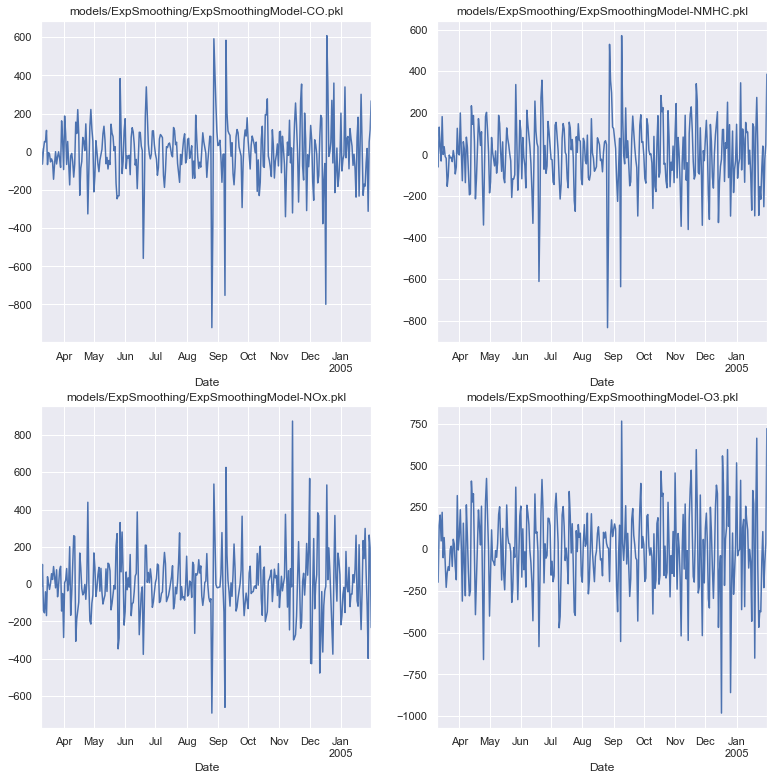

In [60]:
# Plot Residuals for Each Model
fig, ax = plt.subplots(2, 2, figsize=(13, 13))
models = [(load(file), file) for file in file_names]
for model, subplot in zip(models, ax.ravel()):
    model[0].resid.plot(ax=subplot)
    subplot.set_title(model[1])

For the most part, the residuals appear to be homoskedastic.

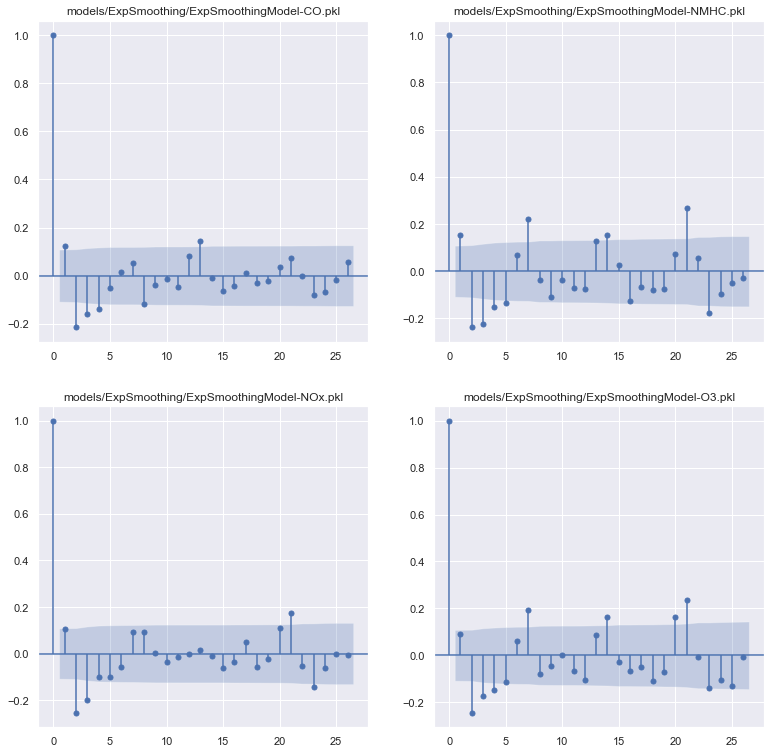

In [61]:
# Plot Autocorrelation of Residuals
fig, ax = plt.subplots(2, 2, figsize=(13, 13))
for model, subplot in zip(models, ax.ravel()):
    plot_acf(model[0].resid, ax=subplot)
    subplot.set_title(model[1])

An ACF plot of the residuals suggests that our forecasts can be improved as the model still does not account for some information, which is left over in the residuals

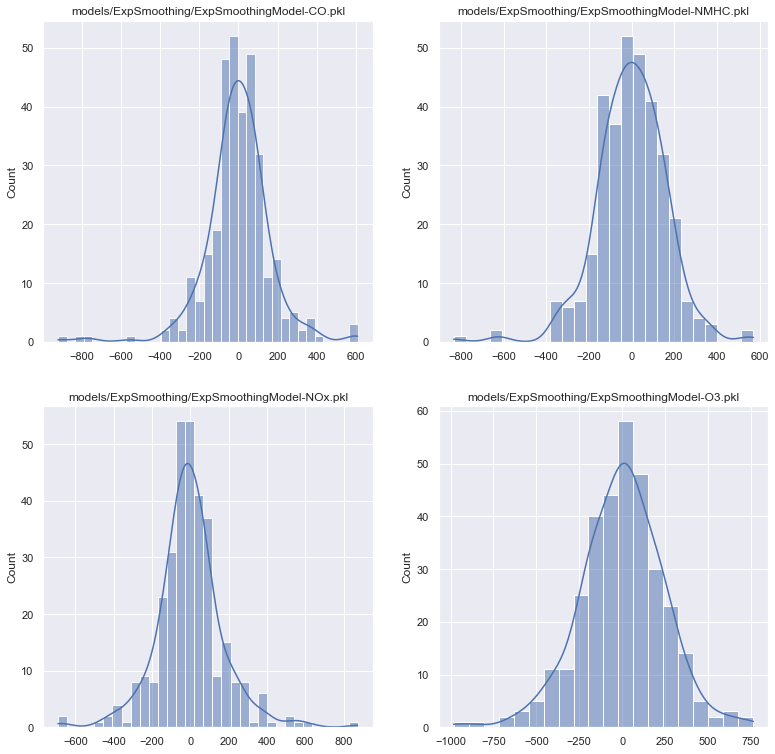

In [62]:
fig, ax = plt.subplots(2, 2, figsize=(13, 13))
for model, subplot in zip(models, ax.ravel()):
    sns.histplot(model[0].resid, ax=subplot, kde=True)
    subplot.set_title(model[1])

The residuals appear to be normally distributed. While not essential, it is preferable for this to be the case.

#### ARIMA

##### Is the Data Stationary?

Before we can engage in modelling, we need to check if our data satisfies certain statistical assumptions that may be made by our models (ARIMA models). This will inform us if further pre-processing is needed. (e.g Differencing is required for our data).

A stationary time series is one whose statistical properties do not depend on the time at which the series is observed. Thus, time series with trends, or with seasonality, are not stationary — the trend and seasonality will affect the value of the time series at different times. 

In general, a stationary time series will have no predictable patterns in the long-term. Time plots will show the series to be roughly horizontal (although some cyclic behaviour is possible), with constant variance.

[Source](https://otexts.com/fpp3/stationarity.html)

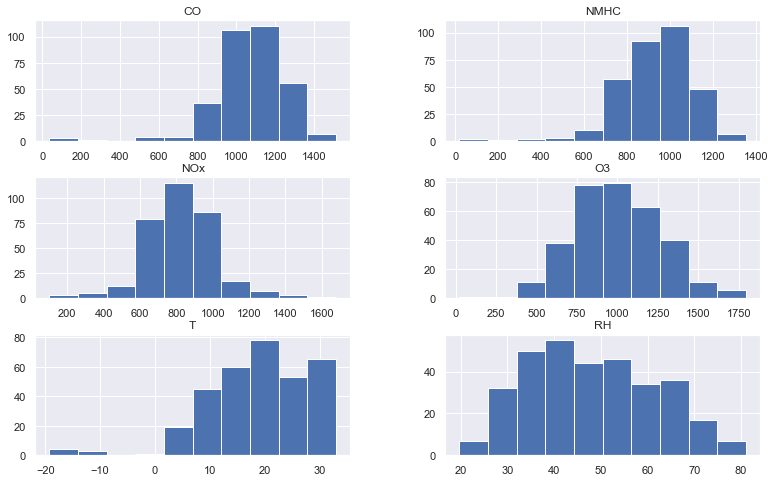

In [63]:
train.hist()
plt.show()

- On a first inspection, it appears that NOx is stationary. It is less clear if the rest are.

In [64]:
grp1 = train[:len(train) // 2]
grp2 = train[len(train) // 2:]

pd.concat([grp1.describe(), grp2.describe()], axis = 1, keys=["Grp1", "Grp2"]).T

count         mean         std         min         25%  \
     Gas                                                            
Grp1 CO    164.0  1070.539168  151.465286  481.753472  988.820313   
     NMHC  164.0   927.128747  134.985533  408.704861  845.799479   
     NOx   164.0   893.988758  149.540845  453.715278  796.906250   
     O3    164.0   938.395664  221.182137  382.131944  797.713542   
     T     164.0    22.043941    8.006580  -12.148958   16.907292   
     RH    164.0    42.732398   10.502532   19.742014   34.805469   
Grp2 CO    164.0  1070.373708  224.413944   36.281250  949.422743   
     NMHC  164.0   935.294398  211.780212   18.552083  811.990451   
     NOx   164.0   764.400089  212.314480  102.520833  644.192708   
     O3    164.0  1064.613842  307.849796   23.541667  834.638889   
     T     164.0    15.350572    8.958539  -19.247917   10.103125   
     RH    164.0    53.801393   13.570700   23.669792   42.797396   

                   50%          75%          max  
     Gas                                          
Grp1 CO    1059.015625  1158.091146  1452.010417  
     NMHC   933.805556  1034.760417  1163.041667  
     NOx    873.776042   975.135417  1376.031250  
     O3     931.322917  1087.466146  1439.041667  
     T       22.357986    28.783594    32.997917  
     RH      41.373785    50.145139    69.340625  
Grp2 CO    1109.421875  1205.656250  1513.208333  
     NMHC   963.611111  1084.477431  1355.104167  
     NOx    733.364583   884.520833  1678.687500  
     O3    1046.812500  1296.317708  1795.291667  
     T       15.054340    21.737326    30.365625  
     RH      55.313715    64.554427    81.104167

- The mean values for Grp 1 and 2 are similar for CO, NMHC, suggesting they are stationary

To tell more concretely if our data is stationary, we will conduct two tests, an Augmented Dickey Fuller Test, and a KPSS test.

###### ADF Test
ADF test is used to determine the presence of unit root in the series, and hence helps in understand if the series is stationary or not. The null and alternate hypothesis of this test are:

Null Hypothesis: The series has a unit root.

Alternate Hypothesis: The series has no unit root.

If the null hypothesis failed to be rejected, this test may provide evidence that the series is non-stationary.

[Reference: Statsmodels](https://www.statsmodels.org/dev/examples/notebooks/generated/stationarity_detrending_adf_kpss.html)


In [65]:
for gas in train[gases].columns:
    print(gas)
    adf_test(train[gas])

CO
Test for Stationarity
Significance Level: 0.05
H0: There is a unit root (non-stationary time series)
H1: There is no unit root (stationary time series)
P-value: 0.000
Used Lag: 0
Reject H0. There is evidence that the time series is stationary.
NMHC
Test for Stationarity
Significance Level: 0.05
H0: There is a unit root (non-stationary time series)
H1: There is no unit root (stationary time series)
P-value: 0.000
Used Lag: 7
Reject H0. There is evidence that the time series is stationary.
NOx
Test for Stationarity
Significance Level: 0.05
H0: There is a unit root (non-stationary time series)
H1: There is no unit root (stationary time series)
P-value: 0.000
Used Lag: 1
Reject H0. There is evidence that the time series is stationary.
O3
Test for Stationarity
Significance Level: 0.05
H0: There is a unit root (non-stationary time series)
H1: There is no unit root (stationary time series)
P-value: 0.000
Used Lag: 8
Reject H0. There is evidence that the time series is stationary.


- According to the ADF test, all of the gas time series are stationary

###### KPSS Test
KPSS is another test for checking the stationarity of a time series. The null and alternate hypothesis for the KPSS test are opposite that of the ADF test.

Null Hypothesis: The process is trend stationary.

Alternate Hypothesis: The series has a unit root (series is not stationary).

We apply this test in addition to the ADF test, to ensure that our data is truly stationary.

In [66]:
for gas in train[gases].columns:
    print(gas)
    kpss_test(train[gas])

CO
Test for Stationarity
Significance Level: 0.05
H0: Process is trend stationary
H1: There is a unit root (non-stationary)
P-value: 0.100
Used Lag: 8
Fail to reject H0. There is insufficient evidence that the time series is not stationary.
NMHC
Test for Stationarity
Significance Level: 0.05
H0: Process is trend stationary
H1: There is a unit root (non-stationary)
P-value: 0.100
Used Lag: 7
Fail to reject H0. There is insufficient evidence that the time series is not stationary.
NOx
Test for Stationarity
Significance Level: 0.05
H0: Process is trend stationary
H1: There is a unit root (non-stationary)
P-value: 0.010
Used Lag: 7
Reject H0. There is evidence that the time series is not stationary.
O3
Test for Stationarity
Significance Level: 0.05
H0: Process is trend stationary
H1: There is a unit root (non-stationary)
P-value: 0.025
Used Lag: 8
Reject H0. There is evidence that the time series is not stationary.


For O3 and NOx, we note that KPSS indicates the data is non-stationary, but the ADF test indicates it is stationary. The series is thus inferred to be difference stationary. 

We will difference the data, and check the differenced data for stationarity.

In [67]:
print("Results of KPSS Test on Differenced Series (O3)")
kpss_test(diff(train['O3']))

print("Results of ADF Test on Differenced Series (O3)")
adf_test(diff(train['O3']))

print("Results of KPSS Test on Differenced Series (NOx)")
kpss_test(diff(train['NOx']))


print("Results of ADF Test on Differenced Series (NOx)")
adf_test(diff(train['NOx']))

Results of KPSS Test on Differenced Series (O3)
Test for Stationarity
Significance Level: 0.05
H0: Process is trend stationary
H1: There is a unit root (non-stationary)
P-value: 0.100
Used Lag: 35
Fail to reject H0. There is insufficient evidence that the time series is not stationary.
Results of ADF Test on Differenced Series (O3)
Test for Stationarity
Significance Level: 0.05
H0: There is a unit root (non-stationary time series)
H1: There is no unit root (stationary time series)
P-value: 0.000
Used Lag: 11
Reject H0. There is evidence that the time series is stationary.
Results of KPSS Test on Differenced Series (NOx)
Test for Stationarity
Significance Level: 0.05
H0: Process is trend stationary
H1: There is a unit root (non-stationary)
P-value: 0.100
Used Lag: 68
Fail to reject H0. There is insufficient evidence that the time series is not stationary.
Results of ADF Test on Differenced Series (NOx)
Test for Stationarity
Significance Level: 0.05
H0: There is a unit root (non-stationa

(-11.331600537208397, 1.1092542125977202e-20, 6)

We observe that after detrending via differencing, the KPSS test shows that O3 and NOx are now truly stationary.

##### Selecting the Order of the ARIMA Model

When using an ARIMA model, it is necessary to specify the order of the model -> p, d, q 

p = order of the Auto Regressive part of the model
d = degree of differencing
q = order of the Moving Average part

It is usually not possible to tell, simply from a time plot, what values of p and q are appropriate for the data. However, it is sometimes possible to use the ACF plot, and the closely related PACF plot, to determine appropriate values for p and q.

If the data are from an ARIMA(p, d,0) or ARIMA(0, d, q) model, then the ACF and PACF plots can be helpful in determining the value of p or q. If p and q are both positive, then the plots do not help in finding suitable values of p and q.

The data may follow an ARIMA(p, d,0) model if the ACF and PACF plots of the differenced data show the following patterns:

- the ACF is exponentially decaying or sinusoidal;
- there is a significant spike at lag p in the PACF, but none beyond lag p.

The data may follow an ARIMA(0,d,q) model if the ACF and PACF plots of the differenced data show the following patterns:

- the PACF is exponentially decaying or sinusoidal;
- there is a significant spike at lag q in the ACF, but none beyond lag q.

[Source](https://otexts.com/fpp3/non-seasonal-arima.html)

Hence, we will use the ACF and PACF plot to estimate the models for each gas, to use as a baseline. We will then fit the identified model, and check that the model residuals are white noise.

###### Carbon Monoxide

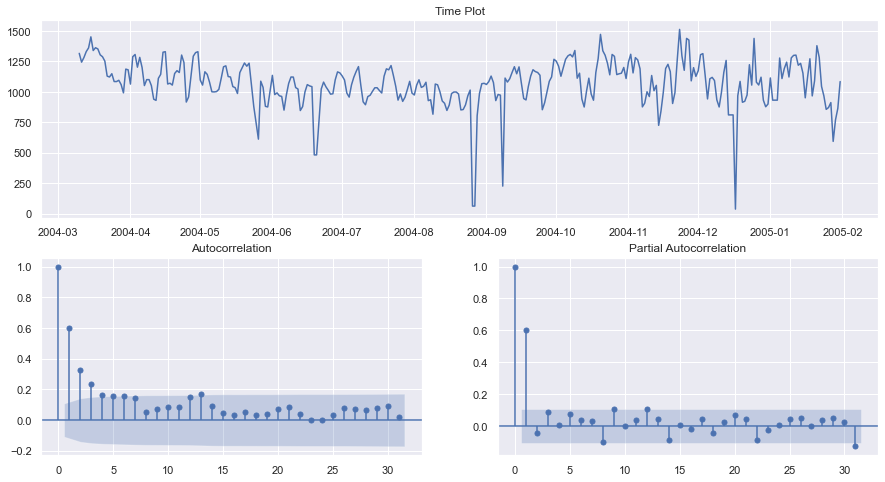

In [68]:
fig = ts_plot(train['CO'])

- Looking at the autocorrelation plot, it appear that the indicated model is an autoregressive model (as the ACF appears to be exponentially decaying)
- Looking then, at the PACF plot, there is a significant spike at lag 1, but none beyond that (there are some lags that are slightly above the confidence interval, but they do not appear to be significant)
- This suggests an ARIMA(1, 0, 0) model

###### Non Metanic Hydrocarbons

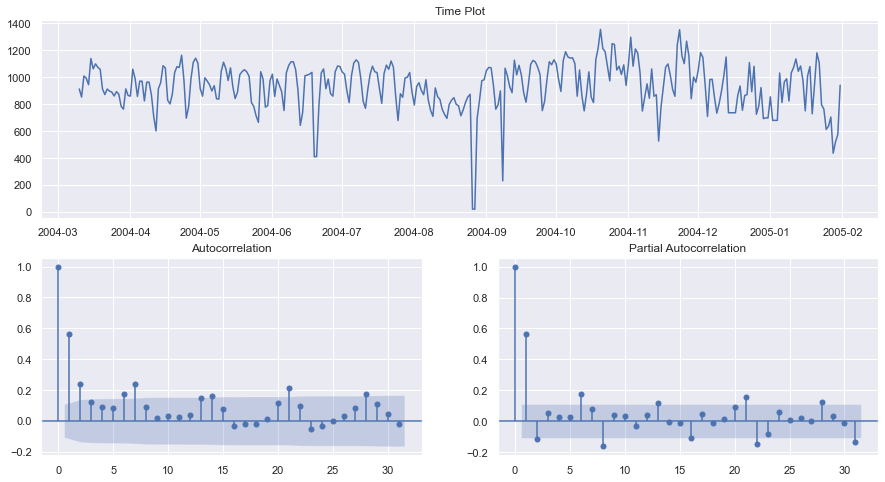

In [69]:
fig = ts_plot(train['NMHC'])

- Order identification is harder here
- Looking at the autocorrelation plot and the partial autocorrelation plot, both appear to tail off after lag 1. 
- This may indicate an ARMA(1,0,1) model

- Another view of the situation is that the ACF plot decays exponentially, while the PACF has a spike at lag one, suggesting an ARMA(1, 0, 0) model

###### Nitrogen Oxides

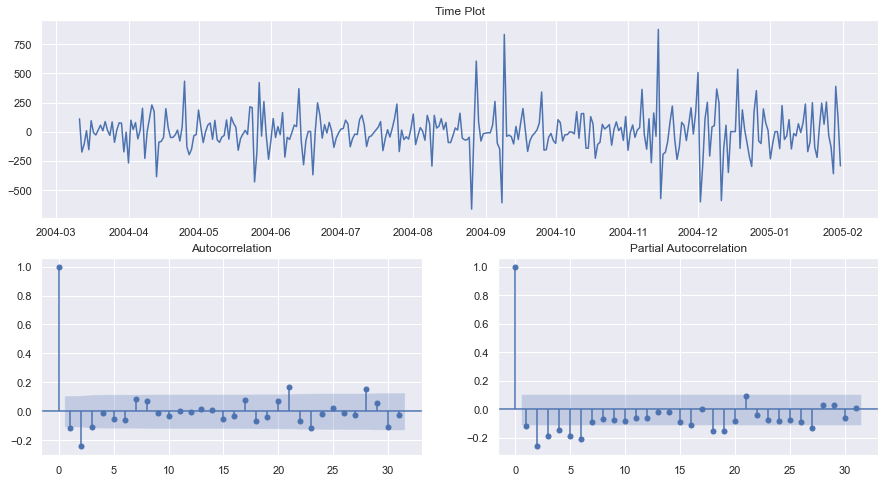

In [70]:
fig = ts_plot(diff(train['NOx']))

- Identification of the order is unclear here
- The autocrrelation plot shows that there are two spikes, with the rest very close to zero. The significant spike at lag 2, suggests a ARIMA(0, 1, 2) model

###### Ozone

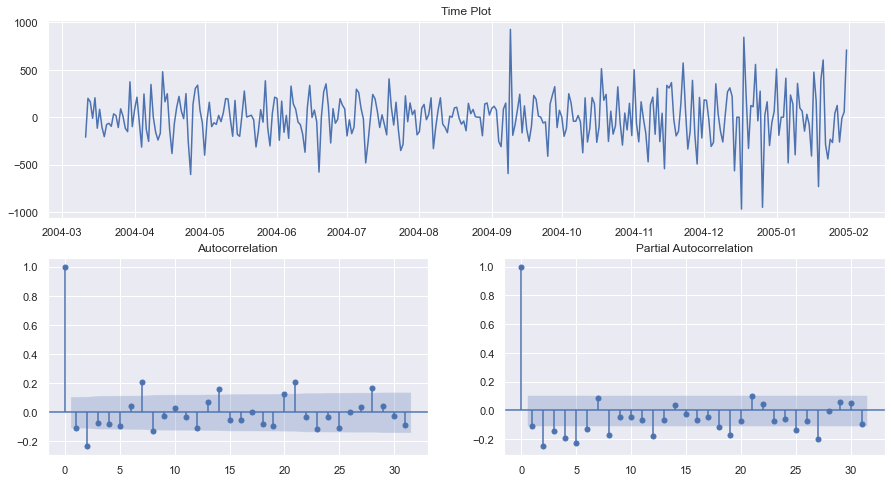

In [71]:
fig = ts_plot(diff(train['O3']))

- The ACF plot shows a few spikes, that occur at intervals of 7, suggesting a seasonal autoregressive term
- This suggests a ARIMA(0, 1, 2) model due to the spike at Lag 2 of the ACF plot

In [72]:
ARIMA_Results = defaultdict(list)
file_names = []
orders = {
    "CO" : (1, 0, 0),
    "NMHC" : (1, 0, 0),
    "NOx" : (0, 1, 2),
    "O3" : (0, 1, 2)
}
for gas in tqdm(gases):
    order = orders[gas]
    final_model, cv_metrics = eval_model(ARIMA, train[gas], model_params = {'order' : order})
    ARIMA_Results[gas] = cv_metrics
    file_name = generate_file_name(f"ARIMA-{order}-{gas}", date=False, location="models/ARIMA")
    file_names.append(file_name)
    final_model.save(file_name)
    history = record_history(f"ARIMA-{order}-{gas}", cv_metrics, gas)
results = parse_results(ARIMA_Results).describe()

  0%|                                                                                                | 0/4 [00:00<?, ?it/s]C:\Users\tienc\mambaforge\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning:

The 'freq' argument in Timestamp is deprecated and will be removed in a future version.

C:\Users\tienc\mambaforge\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning:

The 'freq' argument in Timestamp is deprecated and will be removed in a future version.

C:\Users\tienc\mambaforge\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning:

The 'freq' argument in Timestamp is deprecated and will be removed in a future version.

C:\Users\tienc\mambaforge\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning:

The 'freq' argument in Timestamp is deprecated and will be removed in a future version.

C:\Users\tienc\mambaforge\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning:

The 'freq' argument in Tim

##### Model Analysis

In [73]:
results.T

count         mean          std          min          25%  \
CO   Corrected AIC    5.0  2081.087395  1106.807887   702.082454  1387.907748   
     Train RMSE       5.0   119.770796    19.955859    97.614592   104.370269   
     Test RMSE        5.0   203.780852    47.934444   127.292495   187.595572   
     Final AICc       5.0  4235.842233     0.000000  4235.842233  4235.842233   
NMHC Corrected AIC    5.0  2093.363156  1109.401146   705.708224  1397.445767   
     Train RMSE       5.0   123.767587    18.706951   100.147088   113.034359   
     Test RMSE        5.0   184.375131    42.677632   127.356567   158.001805   
     Final AICc       5.0  4207.303345     0.000000  4207.303345  4207.303345   
NOx  Corrected AIC    5.0  2087.633210  1105.305670   712.024286  1395.732071   
     Train RMSE       5.0   128.554312    14.145936   114.396305   117.770324   
     Test RMSE        5.0   186.683113    52.418233   103.306062   166.265670   
     Final AICc       5.0  4237.602162     0.000000  4237.602162  4237.602162   
O3   Corrected AIC    5.0  2194.879680  1145.106188   761.439642  1470.293839   
     Train RMSE       5.0   181.562977     9.268350   171.305762   176.806747   
     Test RMSE        5.0   292.145983    68.291976   220.932102   225.374992   
     Final AICc       5.0  4471.038997     0.000000  4471.038997  4471.038997   

                            50%          75%          max  
CO   Corrected AIC  2018.018745  2806.433940  3490.994086  
     Train RMSE      116.074965   139.993725   140.800431  
     Test RMSE       227.185746   230.305255   246.525193  
     Final AICc     4235.842233  4235.842233  4235.842233  
NMHC Corrected AIC  2047.186016  2809.563486  3506.912287  
     Train RMSE      120.378797   141.426975   143.850716  
     Test RMSE       196.750617   201.661991   238.104674  
     Final AICc     4207.303345  4207.303345  4207.303345  
NOx  Corrected AIC  2038.570105  2776.171755  3515.667832  
     Train RMSE      126.263957   134.834264   149.506709  
     Test RMSE       217.146996   221.714023   224.982815  
     Final AICc     4237.602162  4237.602162  4237.602162  
O3   Corrected AIC  2171.800857  2907.175338  3663.688723  
     Train RMSE      181.446107   182.011245   196.245022  
     Test RMSE       307.057336   327.899999   379.465486  
     Final AICc     4471.038997  4471.038997  4471.038997

In [74]:
history.sort_values("Mean Test RMSE")

Mean Test RMSE   Final AICc   Gas                              Model Name
5       179.827334  4293.559224  NMHC   SARIMAX-(0, 0, 0)-(2, 0, 2, 8)-NMHC-c
13      184.375131  4207.303345  NMHC                    ARIMA-(1, 0, 0)-NMHC
14      186.683113  4237.602162   NOx                     ARIMA-(0, 1, 2)-NOx
6       188.174343  4296.300275   NOx  SARIMAX-(1, 0, 2)-(2, 0, 0, 21)-NOx-ct
4       191.314699  4361.402101    CO     SARIMAX-(0, 0, 2)-(1, 0, 0, 7)-CO-c
12      203.780852  4235.842233    CO                      ARIMA-(1, 0, 0)-CO
1       204.222215  3340.241747  NMHC                  ExpSmoothingModel-NMHC
9       204.222215  3340.241747  NMHC                  ExpSmoothingModel-NMHC
2       210.039191  3388.009431   NOx                   ExpSmoothingModel-NOx
10      210.039191  3388.009431   NOx                   ExpSmoothingModel-NOx
0       211.118460  3355.023955    CO                    ExpSmoothingModel-CO
8       211.118460  3355.023955    CO                    ExpSmoothingModel-CO
7       290.508750  4453.037354    O3    SARIMAX-(1, 0, 2)-(2, 0, 2, 14)-O3-c
15      292.145983  4471.038997    O3                      ARIMA-(0, 1, 2)-O3
3       325.500094  3608.997874    O3                    ExpSmoothingModel-O3
11      325.500094  3608.997874    O3                    ExpSmoothingModel-O3

In terms of RMSE, the ARIMA models all outperform the Exponential Smoothing Models.

In [75]:
%%capture 
# ^suppress output
models = [load(file) for file in file_names]
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    diagnostics = [model.plot_diagnostics() for model in models]


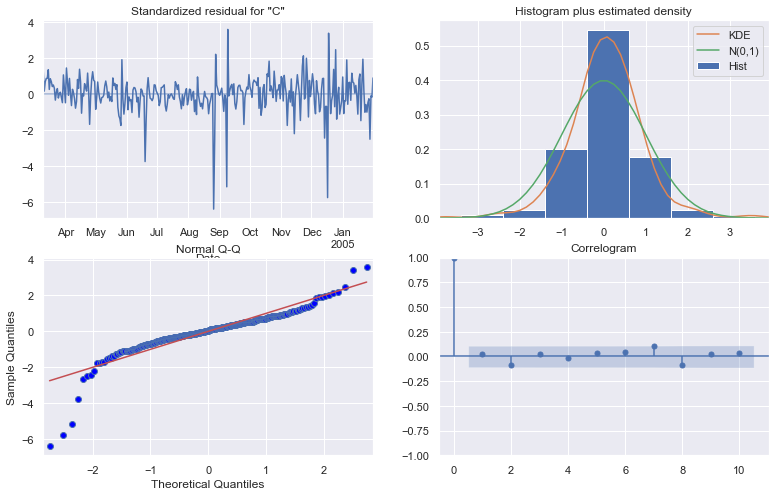

In [76]:
diagnostics[0]

- We observe from the Q-Q plot that the residuals are not normally distributed
- The correlogram does not show any significant correlation, except perhaps at Lag 7

In [77]:
models[0].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                     CO   No. Observations:                  328
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -2114.884
Date:                Wed, 11 Aug 2021   AIC                           4235.768
Time:                        10:02:21   BIC                           4247.147
Sample:                    03-10-2004   HQIC                          4240.308
                         - 01-31-2005                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1070.4566     26.270     40.748      0.000    1018.968    1121.945
ar.L1          0.5999      0.026     23.032      0.000       0.549       0.651
sigma2      2.326e+04    842.337     27.610      0.000    2.16e+04    2.49e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.25   Jarque-Bera (JB):              1657.52
Prob(Q):                              0.62   Prob(JB):                         0.00
Heteroskedasticity (H):               2.15   Skew:                            -1.70
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

- We observe that all the coefficients in the ARIMA model for CO are significant.
- We note that the p-value obtained for the Ljung-Box test is 0.62, hence we would fail to reject the Null hypothesis of independently distributed residuals. Hence the residuals of this ARIMA model likely have no autocorrelation.

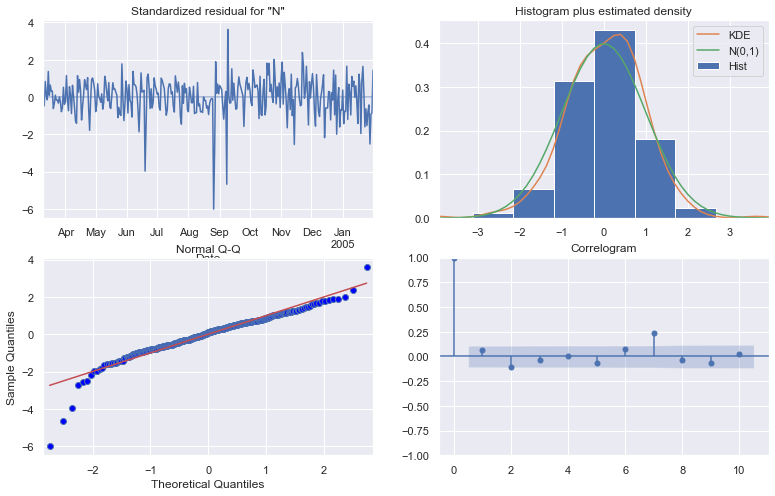

In [78]:
diagnostics[1]

- We observe that for NMHC:
    - Residuals are not normally distributed
    - There is significant correlation at Lag 7. This suggests that the ARIMA model fails to capture some sort of correlation that happens every week (i.e a seasonal pattern)

In [79]:
models[1].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   NMHC   No. Observations:                  328
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -2100.615
Date:                Wed, 11 Aug 2021   AIC                           4207.229
Time:                        10:02:22   BIC                           4218.608
Sample:                    03-10-2004   HQIC                          4211.769
                         - 01-31-2005                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        931.2116     21.383     43.548      0.000     889.301     973.122
ar.L1          0.5628      0.033     17.189      0.000       0.499       0.627
sigma2      2.143e+04    969.832     22.098      0.000    1.95e+04    2.33e+04
===================================================================================
Ljung-Box (L1) (Q):                   1.45   Jarque-Bera (JB):               469.14
Prob(Q):                              0.23   Prob(JB):                         0.00
Heteroskedasticity (H):               1.64   Skew:                            -1.11
Prob(H) (two-sided):                  0.01   Kurtosis:                         8.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

- We observe that all the coefficients in the ARIMA model for NMHC are significant.
- We note that the p-value obtained for the Ljung-Box test is 0.23, hence we would fail to reject the null hypothesis of no autocorrelation in the residuals if we had a significance level of 0.05.

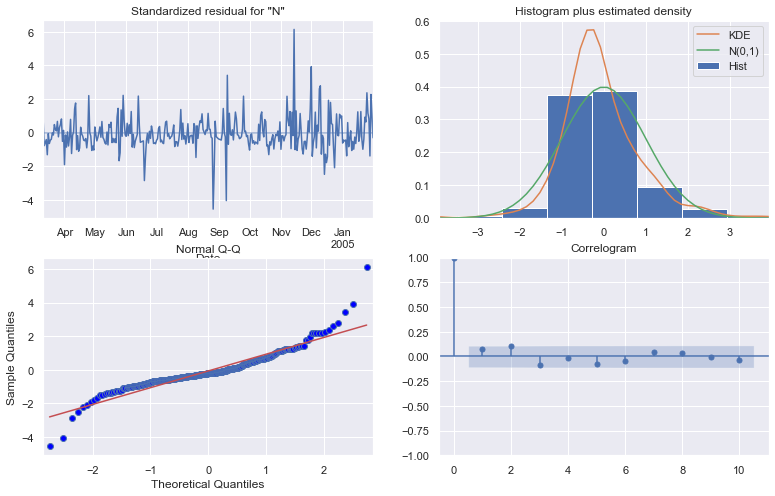

In [80]:
diagnostics[2]

- The residuals for NOx are certainly not normally distributed
- The correlogram does not show any significant correlation, except perhaps at Lag 2.

In [81]:
models[2].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    NOx   No. Observations:                  328
Model:                 ARIMA(0, 1, 2)   Log Likelihood               -2115.764
Date:                Wed, 11 Aug 2021   AIC                           4237.528
Time:                        10:02:22   BIC                           4248.898
Sample:                    03-10-2004   HQIC                          4242.065
                         - 01-31-2005                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4504      0.036    -12.382      0.000      -0.522      -0.379
ma.L2         -0.4856      0.044    -11.004      0.000      -0.572      -0.399
sigma2      2.428e+04    930.545     26.091      0.000    2.25e+04    2.61e+04
===================================================================================
Ljung-Box (L1) (Q):                   1.75   Jarque-Bera (JB):               696.39
Prob(Q):                              0.19   Prob(JB):                         0.00
Heteroskedasticity (H):               2.27   Skew:                             0.88
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

- We observe that all the coefficients in the ARIMA model for NOx are significant.
- We note that the p-value obtained for the Ljung-Box test is 0.19, hence we would fail to reject the null hypothesis of no autocorrelation in the residuals if we had a significance level of 0.05.

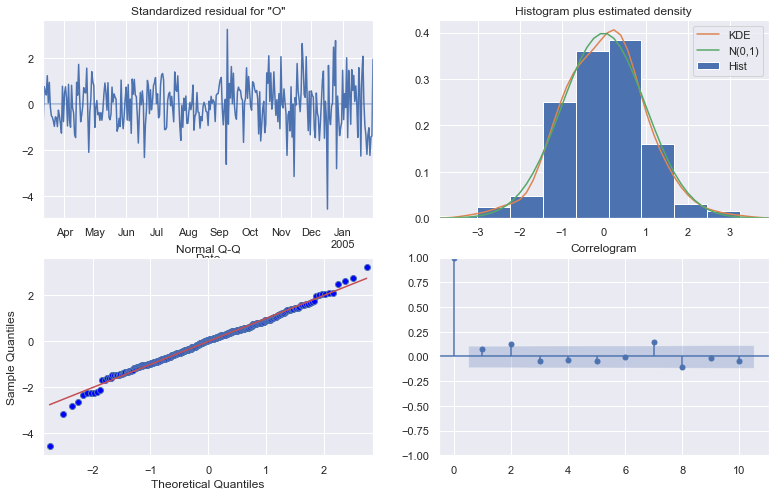

In [82]:
diagnostics[3]

- We observe that the residuals are mostly normally distributed
- There is one significant correlation at Lag 7, suggesting the ARIMA model does not account for seasonality that occurs on a weekly basis
- There is also a smaller correlation at Lag 2

In [83]:
models[3].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                     O3   No. Observations:                  328
Model:                 ARIMA(0, 1, 2)   Log Likelihood               -2232.482
Date:                Wed, 11 Aug 2021   AIC                           4470.965
Time:                        10:02:23   BIC                           4482.335
Sample:                    03-10-2004   HQIC                          4475.501
                         - 01-31-2005                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3902      0.044     -8.845      0.000      -0.477      -0.304
ma.L2         -0.4889      0.048    -10.158      0.000      -0.583      -0.395
sigma2      4.961e+04   2994.017     16.569      0.000    4.37e+04    5.55e+04
===================================================================================
Ljung-Box (L1) (Q):                   1.76   Jarque-Bera (JB):                28.21
Prob(Q):                              0.18   Prob(JB):                         0.00
Heteroskedasticity (H):               2.61   Skew:                            -0.25
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

- We observe that all the coefficients in the ARIMA model for O3 are significant.
- We note that the p-value obtained for the Ljung-Box test is 0.18, hence we would fail to reject the null hypothesis of no autocorrelation in the residuals if we had a significance level of 0.05.

#### SARIMA

##### Identifying Seasonal Orders

The seasonal part of the model consists of terms that are similar to the non-seasonal components of the model, but involve backshifts of the seasonal period.

The seasonal part of an AR or MA model will be seen in the seasonal lags of the PACF and ACF. For example, an ARIMA(0,0,0)(0,0,1,12) model will show:

- a spike at lag 12 in the ACF but no other significant spikes;
- exponential decay in the seasonal lags of the PACF (i.e., at lags 12, 24, 36, …).

Similarly, an ARIMA(0,0,0)(1,0,0,12) model will show:

- exponential decay in the seasonal lags of the ACF;
- a single significant spike at lag 12 in the PACF.
In considering the appropriate seasonal orders for a seasonal ARIMA model, restrict attention to the seasonal lags.

From our EDA, we discovered that we should not seasonally difference our data, as our data does not have strong seasonality ($F_s < 0.64$)

In [121]:
seasonal_lags = [i*7 for i in range(6)]

###### Carbon Monoxide

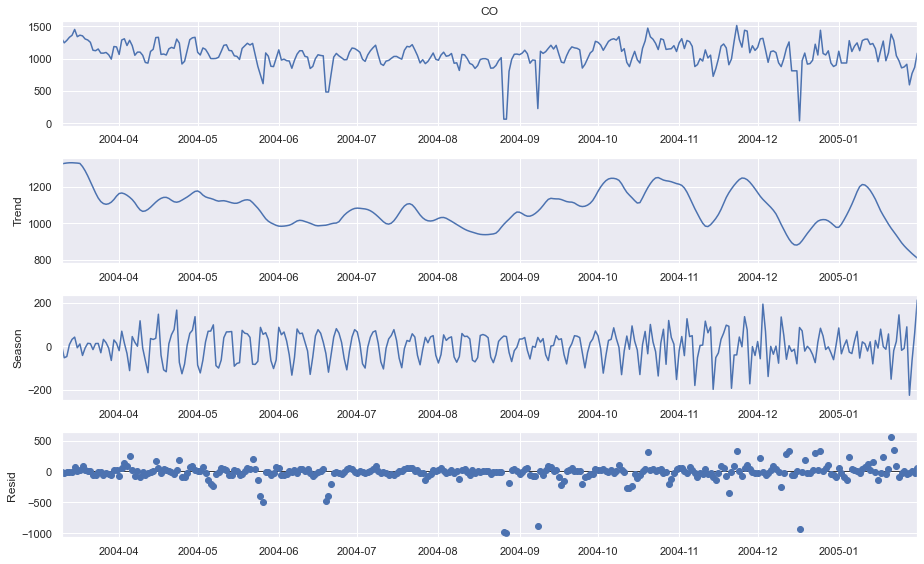

In [84]:
res = STL(df_basic_clean['CO'], robust=True).fit()
res.plot()
plt.show()

Looking at the decomposition of CO, there are four repeating seasons per month, suggesting Weekly seasons. 

In [85]:
decompose_df['Seasonal Strength']['CO']

0.06989822603268647

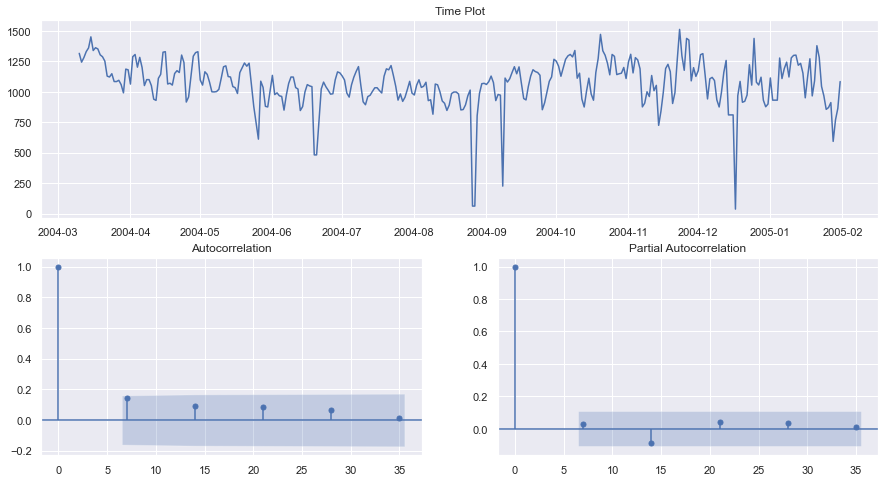

In [122]:
fig = ts_plot(train['CO'], seasonal_lags)

We observe that there do not appear to be any significant spikes at the seasonal lags. This suggests that we would be better served by an ARIMA model without any seasonality.
ARIMA(1, 0, 0)

###### Non Metanic Hydrocarbons

In [87]:
decompose_df['Seasonal Strength']['NMHC']

0.22785812404595274

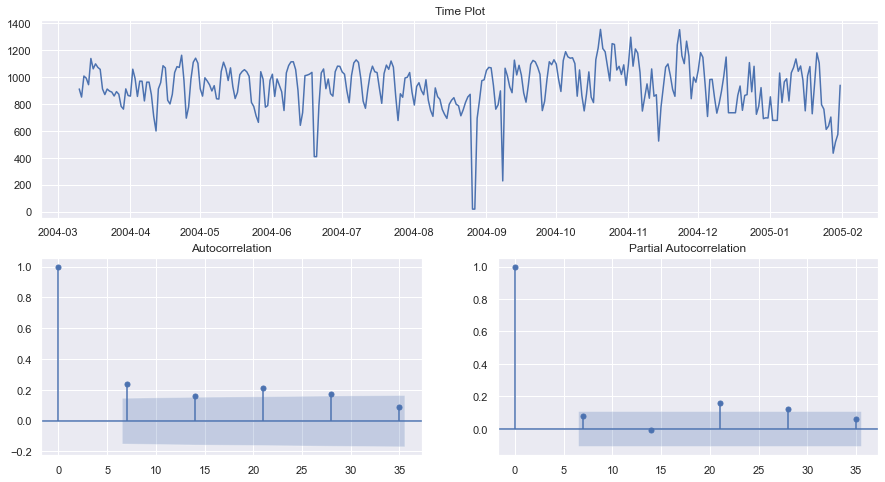

In [123]:
fig = ts_plot(train['NMHC'], seasonal_lags)

- This time series exhibits stronger seasonality. 
- We observe significant spikes in the PACF at Lag 21
- We observe significant spikes in the ACF at lag 7, 14 and 21

- To be more conservative, we will assume a SMA(3) order instead of a (3, 0, 3, 7) seasonal order

###### Nitrogen Oxides

In [89]:
decompose_df['Seasonal Strength']['NOx']

0.10834906205123229

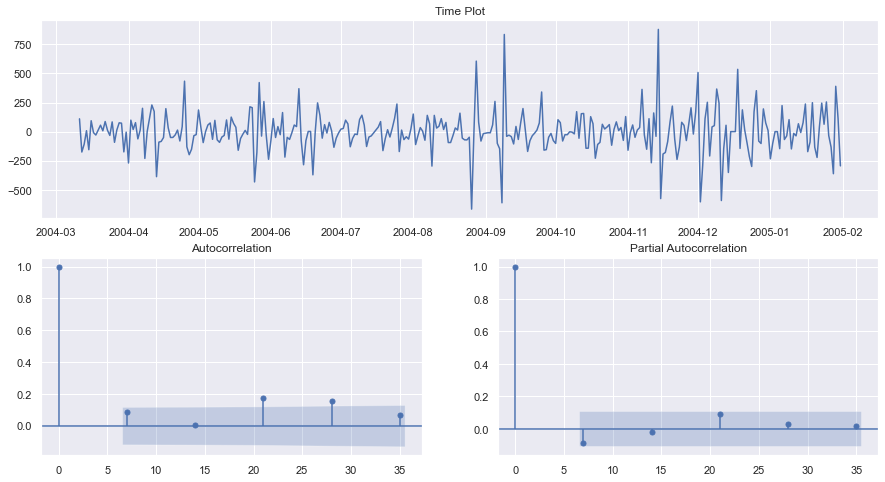

In [124]:
fig = ts_plot(diff(train['NOx'], 1), seasonal_lags)

- The PACF plot decays exponentially to zero
- The ACF plot shows significant seasonal spikes at seasonal lags at 21 and 28
- This might indicate a SMA(3) or SMA(4) model

###### Ozone

In [91]:
decompose_df['Seasonal Strength']['O3']

0.24682814194582414

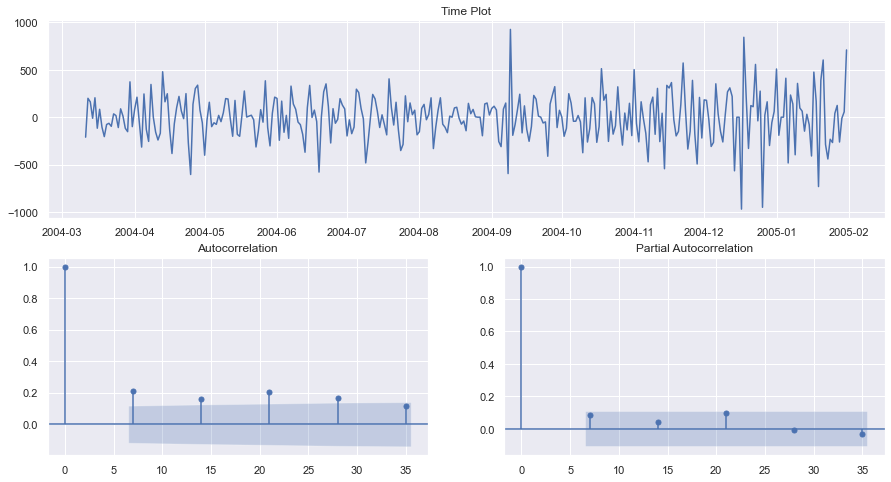

In [126]:
fig = ts_plot(diff(train['O3'], 1), seasonal_lags)

- From analysing the PACF plot, it suggests a SAR(4) model

In [94]:
seasonal_orders = {
    "NMHC" :  (0, 0, 3, 7),
    "NOx" :  (0, 0, 3, 7),
    "O3" :  (4, 0, 0, 7)
}
orders = {
    "CO" : (1, 0, 0),
    "NMHC" : (1, 0, 0),
    "NOx" : (0, 0, 2),
    "O3" : (0, 0, 2)
}
SARIMA_Results = defaultdict(list)
file_names = []

for gas in tqdm(gases):
    order = orders[gas]
    seasonal_order = seasonal_orders[gas] if gas in seasonal_orders else None
    final_model, cv_metrics = eval_model(SARIMAX, train[gas], model_params = {'order' : order} | ({'seasonal_order' : seasonal_order} if seasonal_order is not None else {}))
    SARIMA_Results[gas] = cv_metrics
    file_name = generate_file_name(f"SARIMA-{order}-{seasonal_order}-{gas}", date=False, location="models/SARIMA")
    file_names.append(file_name)
    final_model.save(file_name)
    history = record_history(f"SARIMA-{order}-{seasonal_order}-{gas}", cv_metrics, gas)
results = parse_results(SARIMA_Results).describe()

  0%|                                                                                                | 0/4 [00:00<?, ?it/s]C:\Users\tienc\mambaforge\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.

C:\Users\tienc\mambaforge\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning:

The 'freq' argument in Timestamp is deprecated and will be removed in a future version.

C:\Users\tienc\mambaforge\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.

C:\Users\tienc\mambaforge\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning:

The 'freq' argument in Timestamp is deprecated and will be removed in a future version.

C:\Users\tienc\mambaforge\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning:

The 'freq' argument in Times

##### Model Analysis

In [95]:
results.T

count         mean           std          min  \
CO   Corrected AIC    5.0  1999.781495  1.105235e+03   628.824592   
     Train RMSE       5.0   319.655620  8.750168e+01   244.972195   
     Test RMSE        5.0   188.425442  7.035611e+01    79.192446   
     Final AICc       5.0  4158.156763  0.000000e+00  4158.156763   
NMHC Corrected AIC    5.0  1976.210605  1.095772e+03   618.633332   
     Train RMSE       5.0   250.254615  6.116739e+01   200.017947   
     Test RMSE        5.0   171.129335  5.633427e+01    99.627315   
     Final AICc       5.0  4080.273084  5.084230e-13  4080.273084   
NOx  Corrected AIC    5.0  2015.379326  1.098106e+03   643.287830   
     Train RMSE       5.0   270.716536  6.598742e+01   218.089912   
     Test RMSE        5.0   185.353855  4.204092e+01   121.876394   
     Final AICc       5.0  4164.918747  0.000000e+00  4164.918747   
O3   Corrected AIC    5.0  2093.209703  1.121567e+03   691.514278   
     Train RMSE       5.0   315.529011  7.647023e+01   253.985888   
     Test RMSE        5.0   268.426969  8.878082e+01   189.142764   
     Final AICc       5.0  4362.025871  0.000000e+00  4362.025871   

                            25%          50%          75%          max  
CO   Corrected AIC  1305.827863  1923.217263  2734.165466  3406.872292  
     Train RMSE      266.969183   282.976021   340.560817   462.799884  
     Test RMSE       177.079583   187.465733   235.916535   262.472915  
     Final AICc     4158.156763  4158.156763  4158.156763  4158.156763  
NMHC Corrected AIC  1285.678309  1901.570770  2702.612597  3372.558019  
     Train RMSE      215.904205   220.166144   264.109252   351.075529  
     Test RMSE       131.351129   180.539395   203.063876   241.064960  
     Final AICc     4080.273084  4080.273084  4080.273084  4080.273084  
NOx  Corrected AIC  1332.077476  1966.989851  2707.744880  3426.796592  
     Train RMSE      227.915750   241.152278   287.767970   378.656768  
     Test RMSE       164.618542   206.477335   207.568845   226.228157  
     Final AICc     4164.918747  4164.918747  4164.918747  4164.918747  
O3   Corrected AIC  1382.630815  2065.403170  2794.988389  3531.511862  
     Train RMSE      265.116174   284.301745   333.102497   441.138751  
     Test RMSE       192.697213   235.528689   342.769920   381.996258  
     Final AICc     4362.025871  4362.025871  4362.025871  4362.025871

In [96]:
history.sort_values(["Gas", "Mean Test RMSE"])

Mean Test RMSE   Final AICc   Gas                              Model Name
16      188.425442  4158.156763    CO        SARIMA-(1, 0, 0)-(0, 1, 2, 7)-CO
4       191.314699  4361.402101    CO     SARIMAX-(0, 0, 2)-(1, 0, 0, 7)-CO-c
12      203.780852  4235.842233    CO                      ARIMA-(1, 0, 0)-CO
0       211.118460  3355.023955    CO                    ExpSmoothingModel-CO
8       211.118460  3355.023955    CO                    ExpSmoothingModel-CO
17      171.129335  4080.273084  NMHC      SARIMA-(1, 0, 0)-(0, 1, 2, 7)-NMHC
5       179.827334  4293.559224  NMHC   SARIMAX-(0, 0, 0)-(2, 0, 2, 8)-NMHC-c
13      184.375131  4207.303345  NMHC                    ARIMA-(1, 0, 0)-NMHC
1       204.222215  3340.241747  NMHC                  ExpSmoothingModel-NMHC
9       204.222215  3340.241747  NMHC                  ExpSmoothingModel-NMHC
18      185.353855  4164.918747   NOx       SARIMA-(0, 0, 2)-(0, 1, 2, 7)-NOx
14      186.683113  4237.602162   NOx                     ARIMA-(0, 1, 2)-NOx
6       188.174343  4296.300275   NOx  SARIMAX-(1, 0, 2)-(2, 0, 0, 21)-NOx-ct
2       210.039191  3388.009431   NOx                   ExpSmoothingModel-NOx
10      210.039191  3388.009431   NOx                   ExpSmoothingModel-NOx
19      268.426969  4362.025871    O3        SARIMA-(0, 0, 2)-(0, 1, 2, 7)-O3
7       290.508750  4453.037354    O3    SARIMAX-(1, 0, 2)-(2, 0, 2, 14)-O3-c
15      292.145983  4471.038997    O3                      ARIMA-(0, 1, 2)-O3
3       325.500094  3608.997874    O3                    ExpSmoothingModel-O3
11      325.500094  3608.997874    O3                    ExpSmoothingModel-O3

### Model Improvement

#### Dynamic Regression Methods

An important consideration when estimating a regression with ARMA errors is that all of the variables in the model must first be stationary. If we estimate the model when any of these are non-stationary, the estimated coefficients will not be consistent estimates (and therefore may not be meaningful). One exception to this is the case where non-stationary variables are co-integrated. 
We therefore first difference the non-stationary variables in the model. It is often desirable to maintain the form of the relationship between  
$y_t$ and the predictors, and consequently it is common to difference all of the variables if any of them need differencing. The resulting model is then called a “model in differences,” as distinct from a “model in levels,” which is what is obtained when the original data are used without differencing.

In [159]:
kpss_test(train['T'])

Test for Stationarity
Significance Level: 0.05
H0: Process is trend stationary
H1: There is a unit root (non-stationary)
P-value: 0.010
Used Lag: 10
Reject H0. There is evidence that the time series is not stationary.


(1.1819917571366172, 0.01, 10)

In [160]:
kpss_test(train['RH'])

Test for Stationarity
Significance Level: 0.05
H0: Process is trend stationary
H1: There is a unit root (non-stationary)
P-value: 0.010
Used Lag: 10
Reject H0. There is evidence that the time series is not stationary.


(0.9489476034223001, 0.01, 10)

Since both Temperature and Relative Humidity are not stationary, we need to difference them.

In [161]:
kpss_test(diff(train['T']))

Test for Stationarity
Significance Level: 0.05
H0: Process is trend stationary
H1: There is a unit root (non-stationary)
P-value: 0.100
Used Lag: 52
Fail to reject H0. There is insufficient evidence that the time series is not stationary.


(0.25223410439595656, 0.1, 52)

In [162]:
kpss_test(diff(train['RH']))

Test for Stationarity
Significance Level: 0.05
H0: Process is trend stationary
H1: There is a unit root (non-stationary)
P-value: 0.100
Used Lag: 25
Fail to reject H0. There is insufficient evidence that the time series is not stationary.


(0.09219006717207334, 0.1, 25)

Since we need to difference all our variables, we will need to estimate new orders for CO and NMHC.

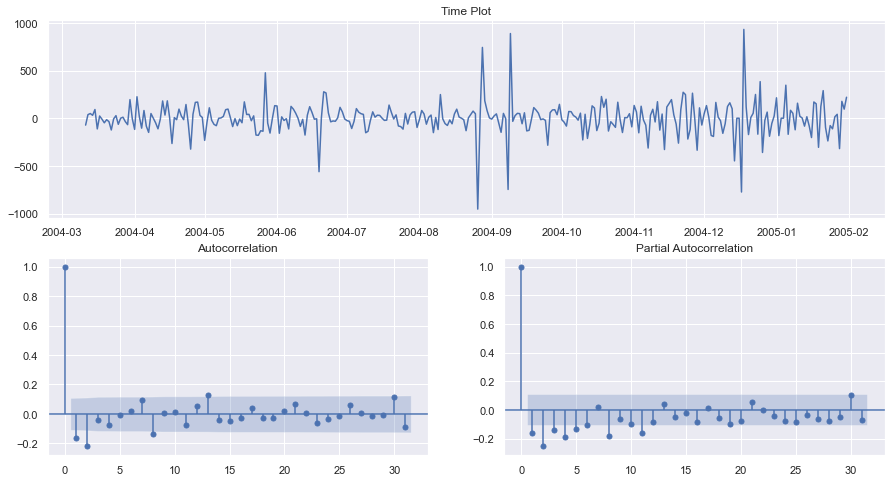

In [165]:
fig = ts_plot(diff(train['CO']))

The ACF plot suggests a MA(2) model.

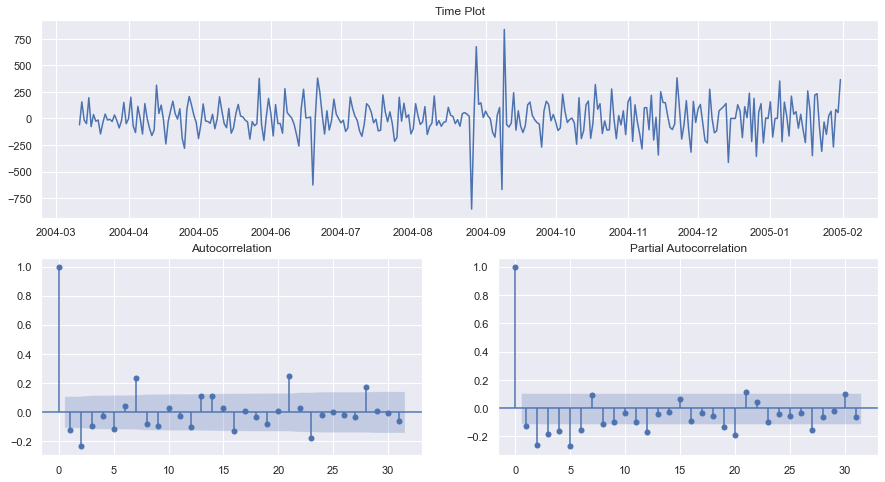

In [166]:
fig = ts_plot(diff(train['NMHC']))

The ACF plot suggests a MA(2) model, and SMA(2)

##### ARIMAX

In [167]:
orders = {
    "CO" : (0, 1, 2),
    "NMHC" : (0, 1, 2),
    "NOx" : (0, 1, 2),
    "O3" : (0, 1, 2)
}
ARIMAX_Results = defaultdict(list)
arimax_file_names = []

for gas in tqdm(gases):
    order = orders[gas]
    exog = train[['T', 'RH']]
    final_model, cv_metrics = eval_model(ARIMA, train[gas], model_params = {'order' : order, 'exog' : exog})
    ARIMAX_Results[gas] = cv_metrics
    file_name = generate_file_name(f"ARIMAX-{order}-{gas}", date=False, location="models/ARIMAX")
    arimax_file_names.append(file_name)
    final_model.save(file_name)
    history = record_history(f"ARIMAX-{order}-{gas}", cv_metrics, gas)
results = parse_results(ARIMAX_Results).describe()

  0%|                                                                                                | 0/4 [00:00<?, ?it/s]C:\Users\tienc\mambaforge\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning:

The 'freq' argument in Timestamp is deprecated and will be removed in a future version.

C:\Users\tienc\mambaforge\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning:

The 'freq' argument in Timestamp is deprecated and will be removed in a future version.

C:\Users\tienc\mambaforge\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning:

The 'freq' argument in Timestamp is deprecated and will be removed in a future version.

C:\Users\tienc\mambaforge\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning:

The 'freq' argument in Timestamp is deprecated and will be removed in a future version.

C:\Users\tienc\mambaforge\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning:

The 'freq' argument in Tim

In [168]:
results.T

count         mean          std          min          25%  \
CO   Corrected AIC    5.0  2053.515314  1101.193706   685.336593  1363.915554   
     Train RMSE       5.0   111.798467    21.538479    89.092059    94.312032   
     Test RMSE        5.0   184.094647    68.086611    90.520812   151.468311   
     Final AICc       5.0  4201.274535     0.000000  4201.274535  4201.274535   
NMHC Corrected AIC    5.0  2073.345624  1110.911179   690.076464  1374.230422   
     Train RMSE       5.0   118.393328    21.544292    93.175713   105.120062   
     Test RMSE        5.0   186.869338    51.427197   130.195377   168.108760   
     Final AICc       5.0  4188.364642     0.000000  4188.364642  4188.364642   
NOx  Corrected AIC    5.0  2089.665562  1105.544482   714.268063  1398.247008   
     Train RMSE       5.0   127.342084    14.933561   112.723011   115.164575   
     Test RMSE        5.0   187.107662    53.267943   103.201036   164.727366   
     Final AICc       5.0  4235.024342     0.000000  4235.024342  4235.024342   
O3   Corrected AIC    5.0  2193.367837  1141.038558   764.372850  1472.975676   
     Train RMSE       5.0   178.476229     8.955124   167.815707   175.372719   
     Test RMSE        5.0   301.368166    66.325058   213.230809   251.354873   
     Final AICc       5.0  4461.747129     0.000000  4461.747129  4461.747129   

                            50%          75%          max  
CO   Corrected AIC  1979.722678  2783.290151  3455.311593  
     Train RMSE      107.088160   132.847447   135.652637  
     Test RMSE       196.389775   208.765158   273.329179  
     Final AICc     4201.274535  4201.274535  4201.274535  
NMHC Corrected AIC  2015.363732  2796.863780  3490.193724  
     Train RMSE      112.087909   139.953128   141.629830  
     Test RMSE       179.263032   186.500727   270.278793  
     Final AICc     4188.364642  4188.364642  4188.364642  
NOx  Corrected AIC  2038.063159  2779.669345  3518.080237  
     Train RMSE      125.127770   134.625457   149.069606  
     Test RMSE       218.625576   221.320852   227.663479  
     Final AICc     4235.024342  4235.024342  4235.024342  
O3   Corrected AIC  2169.472765  2902.692333  3657.325559  
     Train RMSE      178.255097   178.409873   192.527749  
     Test RMSE       322.865700   354.198760   365.190688  
     Final AICc     4461.747129  4461.747129  4461.747129

In [169]:
history.sort_values(['Gas', 'Mean Test RMSE'])

Mean Test RMSE   Final AICc   Gas                              Model Name
24      180.208778  4126.668642    CO       SARIMAX-(1, 0, 0)-(0, 1, 2, 7)-CO
28      184.094647  4201.274535    CO                     ARIMAX-(0, 1, 2)-CO
16      188.425442  4158.156763    CO        SARIMA-(1, 0, 0)-(0, 1, 2, 7)-CO
4       191.314699  4361.402101    CO     SARIMAX-(0, 0, 2)-(1, 0, 0, 7)-CO-c
20      192.106326  4207.460872    CO                     ARIMAX-(1, 0, 0)-CO
12      203.780852  4235.842233    CO                      ARIMA-(1, 0, 0)-CO
0       211.118460  3355.023955    CO                    ExpSmoothingModel-CO
8       211.118460  3355.023955    CO                    ExpSmoothingModel-CO
17      171.129335  4080.273084  NMHC      SARIMA-(1, 0, 0)-(0, 1, 2, 7)-NMHC
25      177.472586  4066.527868  NMHC     SARIMAX-(1, 0, 0)-(0, 1, 2, 7)-NMHC
5       179.827334  4293.559224  NMHC   SARIMAX-(0, 0, 0)-(2, 0, 2, 8)-NMHC-c
21      183.180592  4196.138547  NMHC                   ARIMAX-(1, 0, 0)-NMHC
13      184.375131  4207.303345  NMHC                    ARIMA-(1, 0, 0)-NMHC
29      186.869338  4188.364642  NMHC                   ARIMAX-(0, 1, 2)-NMHC
1       204.222215  3340.241747  NMHC                  ExpSmoothingModel-NMHC
9       204.222215  3340.241747  NMHC                  ExpSmoothingModel-NMHC
18      185.353855  4164.918747   NOx       SARIMA-(0, 0, 2)-(0, 1, 2, 7)-NOx
14      186.683113  4237.602162   NOx                     ARIMA-(0, 1, 2)-NOx
22      187.107662  4235.024342   NOx                    ARIMAX-(0, 1, 2)-NOx
30      187.107662  4235.024342   NOx                    ARIMAX-(0, 1, 2)-NOx
6       188.174343  4296.300275   NOx  SARIMAX-(1, 0, 2)-(2, 0, 0, 21)-NOx-ct
26      191.167423  4155.154202   NOx      SARIMAX-(0, 0, 2)-(0, 1, 2, 7)-NOx
2       210.039191  3388.009431   NOx                   ExpSmoothingModel-NOx
10      210.039191  3388.009431   NOx                   ExpSmoothingModel-NOx
19      268.426969  4362.025871    O3        SARIMA-(0, 0, 2)-(0, 1, 2, 7)-O3
27      286.664786  4346.931291    O3       SARIMAX-(0, 0, 2)-(0, 1, 2, 7)-O3
7       290.508750  4453.037354    O3    SARIMAX-(1, 0, 2)-(2, 0, 2, 14)-O3-c
15      292.145983  4471.038997    O3                      ARIMA-(0, 1, 2)-O3
23      301.368166  4461.747129    O3                     ARIMAX-(0, 1, 2)-O3
31      301.368166  4461.747129    O3                     ARIMAX-(0, 1, 2)-O3
3       325.500094  3608.997874    O3                    ExpSmoothingModel-O3
11      325.500094  3608.997874    O3                    ExpSmoothingModel-O3

##### SARIMAX

In [100]:
seasonal_orders = {
    "NMHC" :  (0, 0, 3, 7),
    "NOx" :  (0, 0, 3, 7),
    "O3" :  (4, 0, 0, 7)
}
orders = {
    "CO" : (0, 1, 2),
    "NMHC" : (0, 1, 2),
    "NOx" : (0, 1, 2),
    "O3" : (0, 1, 2)
}
SARIMAX_Results = defaultdict(list)
sarimax_file_names = []

for gas in tqdm(gases):
    order = orders[gas]
    seasonal_order = seasonal_orders[gas] if gas in seasonal_orders else None
    exog = train[['T', 'RH']]
    final_model, cv_metrics = eval_model(SARIMAX, train[gas], model_params = {'order' : order, 'seasonal_order' : seasonal_order, 'exog' : exog})
    SARIMAX_Results[gas] = cv_metrics
    file_name = generate_file_name(f"SARIMAX-{order}-{seasonal_order}-{gas}", date=False, location="models/SARIMAX")
    sarimax_file_names.append(file_name)
    final_model.save(file_name)
    history = record_history(f"SARIMAX-{order}-{seasonal_order}-{gas}", cv_metrics, gas)
results = parse_results(SARIMAX_Results).describe()

  0%|                                                                                                | 0/4 [00:00<?, ?it/s]C:\Users\tienc\mambaforge\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.

C:\Users\tienc\mambaforge\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning:

The 'freq' argument in Timestamp is deprecated and will be removed in a future version.

C:\Users\tienc\mambaforge\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.

C:\Users\tienc\mambaforge\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning:

The 'freq' argument in Timestamp is deprecated and will be removed in a future version.

C:\Users\tienc\mambaforge\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning:

The 'freq' argument in Times

In [101]:
results

CO                                               NMHC  \
      Corrected AIC  Train RMSE   Test RMSE   Final AICc Corrected AIC   
count      5.000000    5.000000    5.000000     5.000000      5.000000   
mean    1988.691371  282.793444  180.208778  4126.668642   1973.159527   
std     1098.556842   93.376878   70.198481     0.000000   1097.111526   
min      623.136184  203.671692   84.581462  4126.668642    609.319331   
25%     1301.987122  229.838133  128.663851  4126.668642   1287.092597   
50%     1910.432294  246.075538  213.848323  4126.668642   1898.115900   
75%     2725.830381  295.712353  224.064118  4126.668642   2703.575052   
max     3382.070875  438.669505  249.886136  4126.668642   3367.694755   

                                                      NOx              \
       Train RMSE   Test RMSE    Final AICc Corrected AIC  Train RMSE   
count    5.000000    5.000000  5.000000e+00      5.000000    5.000000   
mean   244.455912  177.472586  4.066528e+03   2015.859279  246.423975   
std     73.304614   50.031764  5.084230e-13   1100.803392   36.149146   
min    180.271788  104.128864  4.066528e+03    638.138331  219.592859   
25%    203.607043  172.304054  4.066528e+03   1333.107298  221.905291   
50%    217.301691  178.948363  4.066528e+03   1967.743016  226.661358   
75%    254.728592  187.379577  4.066528e+03   2711.393662  259.766227   
max    366.370448  244.602073  4.066528e+03   3428.914089  304.194137   

                                          O3                          \
        Test RMSE   Final AICc Corrected AIC  Train RMSE   Test RMSE   
count    5.000000     5.000000      5.000000    5.000000    5.000000   
mean   191.167423  4155.154202   2091.677520  309.742505  286.664786   
std     42.594345     0.000000   1118.054837   99.918620   67.738083   
min    119.318252  4155.154202    689.922225  222.333757  198.511422   
25%    185.966799  4155.154202   1385.958785  242.472802  232.312484   
50%    211.208962  4155.154202   2068.105943  283.955164  317.591597   
75%    215.136753  4155.154202   2792.511193  326.421061  327.500694   
max    224.206352  4155.154202   3521.889454  473.529742  357.407733   

                    
        Final AICc  
count     5.000000  
mean   4346.931291  
std       0.000000  
min    4346.931291  
25%    4346.931291  
50%    4346.931291  
75%    4346.931291  
max    4346.931291

In [102]:
history.sort_values(['Gas', 'Mean Test RMSE'])

Mean Test RMSE   Final AICc   Gas                              Model Name
24      180.208778  4126.668642    CO       SARIMAX-(1, 0, 0)-(0, 1, 2, 7)-CO
16      188.425442  4158.156763    CO        SARIMA-(1, 0, 0)-(0, 1, 2, 7)-CO
4       191.314699  4361.402101    CO     SARIMAX-(0, 0, 2)-(1, 0, 0, 7)-CO-c
20      192.106326  4207.460872    CO                     ARIMAX-(1, 0, 0)-CO
12      203.780852  4235.842233    CO                      ARIMA-(1, 0, 0)-CO
0       211.118460  3355.023955    CO                    ExpSmoothingModel-CO
8       211.118460  3355.023955    CO                    ExpSmoothingModel-CO
17      171.129335  4080.273084  NMHC      SARIMA-(1, 0, 0)-(0, 1, 2, 7)-NMHC
25      177.472586  4066.527868  NMHC     SARIMAX-(1, 0, 0)-(0, 1, 2, 7)-NMHC
5       179.827334  4293.559224  NMHC   SARIMAX-(0, 0, 0)-(2, 0, 2, 8)-NMHC-c
21      183.180592  4196.138547  NMHC                   ARIMAX-(1, 0, 0)-NMHC
13      184.375131  4207.303345  NMHC                    ARIMA-(1, 0, 0)-NMHC
1       204.222215  3340.241747  NMHC                  ExpSmoothingModel-NMHC
9       204.222215  3340.241747  NMHC                  ExpSmoothingModel-NMHC
18      185.353855  4164.918747   NOx       SARIMA-(0, 0, 2)-(0, 1, 2, 7)-NOx
14      186.683113  4237.602162   NOx                     ARIMA-(0, 1, 2)-NOx
22      187.107662  4235.024342   NOx                    ARIMAX-(0, 1, 2)-NOx
6       188.174343  4296.300275   NOx  SARIMAX-(1, 0, 2)-(2, 0, 0, 21)-NOx-ct
26      191.167423  4155.154202   NOx      SARIMAX-(0, 0, 2)-(0, 1, 2, 7)-NOx
2       210.039191  3388.009431   NOx                   ExpSmoothingModel-NOx
10      210.039191  3388.009431   NOx                   ExpSmoothingModel-NOx
19      268.426969  4362.025871    O3        SARIMA-(0, 0, 2)-(0, 1, 2, 7)-O3
27      286.664786  4346.931291    O3       SARIMAX-(0, 0, 2)-(0, 1, 2, 7)-O3
7       290.508750  4453.037354    O3    SARIMAX-(1, 0, 2)-(2, 0, 2, 14)-O3-c
15      292.145983  4471.038997    O3                      ARIMA-(0, 1, 2)-O3
23      301.368166  4461.747129    O3                     ARIMAX-(0, 1, 2)-O3
3       325.500094  3608.997874    O3                    ExpSmoothingModel-O3
11      325.500094  3608.997874    O3                    ExpSmoothingModel-O3

In [103]:
%%capture 
# ^suppress output
models = [load(file) for file in sarimax_file_names]
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    diagnostics = [model.plot_diagnostics() for model in models]


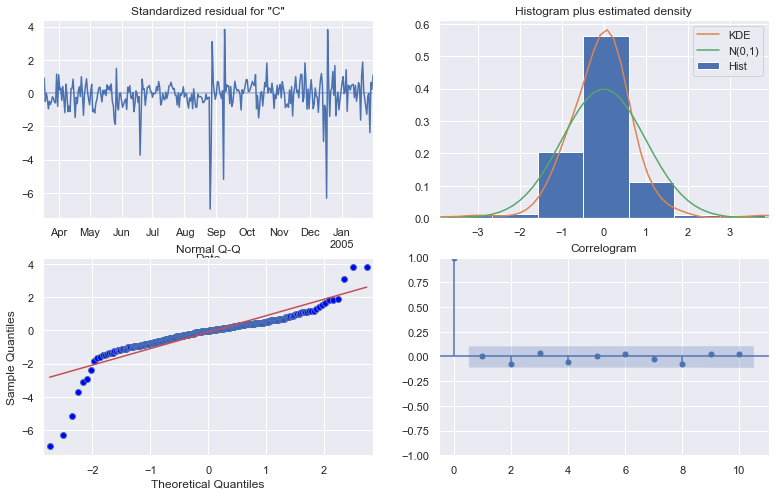

In [104]:
diagnostics[0]

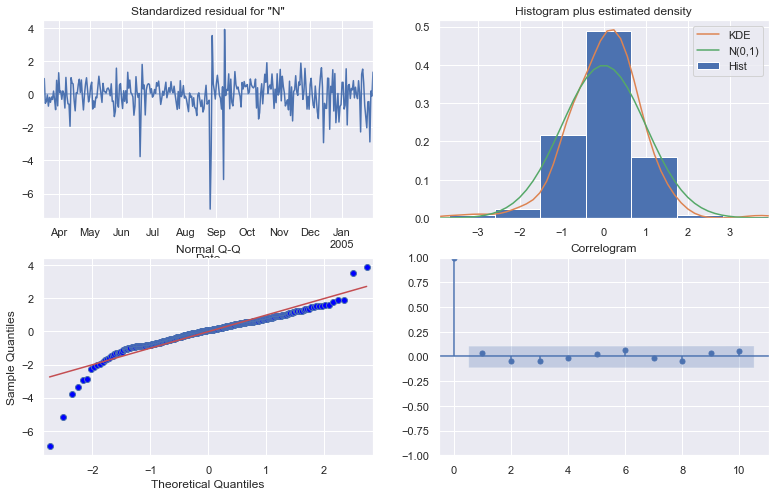

In [105]:
diagnostics[1]

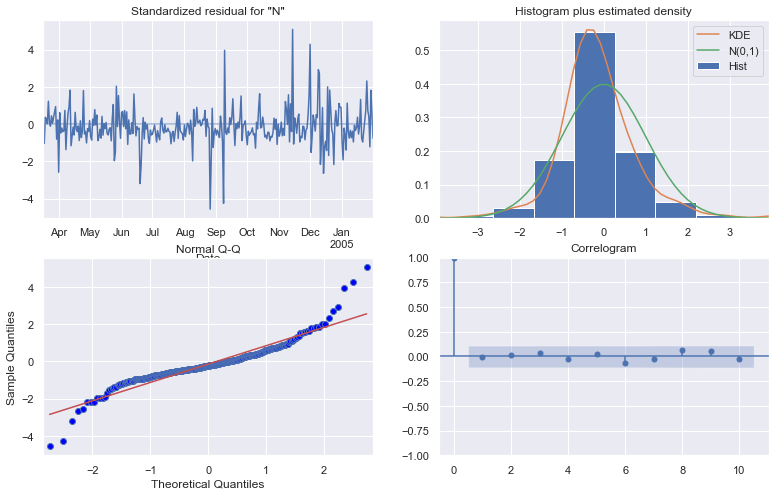

In [106]:
diagnostics[2]

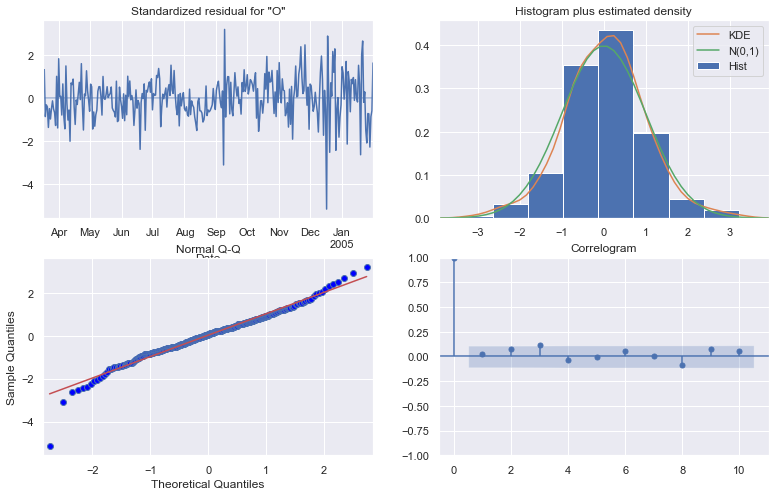

In [107]:
diagnostics[3]

#### Hyperparameter Tuning

##### Best Order

##### CO

In [128]:
def get_param_grid(data, gas,param_grid, exog=None):
    data = data[gas]
    # Select order of differencing
    ## Try seasonal differencing
    d = param_grid['d']
    D = param_grid['D']
#     if 'D' in param_grid:
#         for i in param_grid['D']:
#             kpss_result = kpss(diff(data, i))
#             if kpss_result[0] >= 0.05: # if seasonal difference is stationary
#                 D = i
#                 break
          
#     ## Try first difference
#     for i in param_grid['d']:
#         kpss_result = kpss(diff(data, i + D))
#         if kpss_result[0] >= 0.05:
#             d = i
#             break

    orders = [
        (p, d, q) for p in param_grid['p'] for q in param_grid['q']
    ]

    if 'P' in param_grid and 'Q' in param_grid and 'm' in param_grid:
        seasonal_orders = [
        (P, D, Q, m) for P in param_grid['P'] for Q in param_grid['Q'] for m in param_grid['m']
    ]
    else:
        seasonal_orders = [None]

    if 'trend' in param_grid:
       trends = param_grid['trend']
    else:
        trends = ['n'] 
    return [              {
                        'order' : order,
                        'seasonal_order' : seasonal_order,
                        'trend' : trend
                    } | ({
                        'exog' : exog
                    } if exog is not None else None) for order in orders for seasonal_order in seasonal_orders for trend in trends
]

In [109]:
np.inf

inf

In [172]:
def score_aic(data, param, model, name, exog):
    if not exog:
        del param['exog']
    try:
        cur_model = model(data, **param).fit()
        # cur_model.save(name)
        aicc = cur_model.aicc
    except:
        aicc = np.inf
    return aicc 

In [171]:
def score_cv(data, param, model, name, exog):
    if not exog:
        del param['exog']
    try:
        cur_model, cv_metrics = eval_model(model, data, model_params=param, refit=True)
        # cur_model.save(name)
    except:
        return np.inf
    return np.mean(cv_metrics['Test RMSE'])

In [173]:
from joblib import Parallel, delayed

def grid_search(data, gas,param_grid,model = SARIMAX,  eval_method='AIC', parallel=True, exog=True):
    """
    Performs a grid search on SARIMAX parameters
    """
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        warnings.simplefilter("error", UserWarning) # throw warning for non-invertible/stationary models
        if exog:
            file_names = [generate_file_name(f"SARIMAX-{params['order']}-{params['seasonal_order']}-{params['trend']}-{gas}", date=False, location="models/SARIMAX") for params in param_grid]
        else:
            file_names = [generate_file_name(f"SARIMA-{params['order']}-{params['seasonal_order']}-{params['trend']}-{gas}", date=False, location="models/SARIMA") for params in param_grid]
        parallel_instance = Parallel(n_jobs=-1, verbose=5)
        score_funcs = {
            'AIC' : score_aic,
            'CV' : score_cv
        }
        if parallel:
            tasks = (
                delayed(score_funcs[eval_method])(data, param, model, name, exog) for param, name in zip(param_grid, file_names)
            )
            results = parallel_instance(tasks)
        else:
            results = [
                score_funcs[eval_method](data, param, model, name, exog) for param, name in zip(param_grid, file_names)
            ]
        results = np.array(results)
        file_names = np.array(file_names)
    best_models = np.argsort(results)
    return results[best_models][:5], file_names[best_models][:5]



In [ ]:
# def stepwise_search(data, gas, max_p, max_d, max_q, max_P, max_D, max_Q, eval_method='CV', parallel = True):
    

In [170]:
CO_ParamGrid = get_param_grid(train, 'CO', {
    'p' : range(3),
    'P' : range(3),
    'd' : 1,
    'D' : 0,
    'q' : range(3),
    'Q' : range(3),
    'm' : [7],
    'trend' : ['n', 'c', 'ct'],
    
}, train[['T','RH']])

best_scores, best_models = grid_search(train['CO'], 'CO', param_grid=CO_ParamGrid, eval_method='AIC', parallel=True)
print("Best Scores:", best_scores)
print("Best Models:", best_models)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   13.9s


Best Scores: [4191.52727974 4192.36810228 4193.5935713  4193.99174166 4194.72468245]
Best Models: ['models/SARIMAX/SARIMAX-(1, 1, 1)-(1, 0, 1, 7)-n-CO.pkl'
 'models/SARIMAX/SARIMAX-(2, 1, 2)-(1, 0, 1, 7)-n-CO.pkl'
 'models/SARIMAX/SARIMAX-(1, 1, 1)-(2, 0, 1, 7)-n-CO.pkl'
 'models/SARIMAX/SARIMAX-(1, 1, 1)-(1, 0, 2, 7)-n-CO.pkl'
 'models/SARIMAX/SARIMAX-(2, 1, 2)-(2, 0, 1, 7)-n-CO.pkl']


[Parallel(n_jobs=-1)]: Done 243 out of 243 | elapsed:   27.4s finished


```
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.

[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   46.6s

[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  4.1min

[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:  9.0min

[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed: 16.5min

[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed: 26.2min

[Parallel(n_jobs=-1)]: Done 858 tasks      | elapsed: 38.1min

[231.3229221357803, 179.38092526356047, 195.418793239153, 231.3229221357803, 179.38092526356047]

Best Score: 177.57518444769087

Best Model: models/SARIMAX/SARIMAX-(0, 0, 2)-(1, 0, 0, 7)-c-CO.pkl

[Parallel(n_jobs=-1)]: Done 972 out of 972 | elapsed: 45.8min finished
```

In [174]:
params = [
 {
     "order" : (1, 1, 1),
     "seasonal_order" : (1, 0, 1, 7),
     "trend" : "n"
 },
    {
         "order" : (2, 1, 2),
     "seasonal_order" : (1, 0, 1, 7),
     "trend" : "n"
    },
        {
         "order" : (1, 1, 1),
     "seasonal_order" : (2, 0, 1, 7),
     "trend" : "n"
    },
        {
         "order" : (1, 1, 1),
     "seasonal_order" : (1, 0, 2, 7),
     "trend" : "n"
    },
        {
         "order" : (2, 1, 2),
     "seasonal_order" : (2, 0, 1, 7),
     "trend" : "n"
    }
]
tuned_results = {}
with warnings.catch_warnings():
    warnings.simplefilter("ignore", ConvergenceWarning)
    warnings.simplefilter("ignore", FutureWarning)
    gas = 'CO'
    for param in tqdm(params):
        order = param['order']
        seasonal_order = param['seasonal_order']
        trend = param['trend']
        file_name = generate_file_name(f"SARIMAX-{order}-{seasonal_order}-{gas}-{trend}", date=False, location="models/SARIMAX")
        exog = train[['T', 'RH']]
        final_model, cv_metrics = eval_model(SARIMAX, train[gas], model_params = {'order' : order, 'seasonal_order' : seasonal_order, 'exog' : exog, 'trend' : trend})
        co_tuned_results[file_name] = cv_metrics
    tuned_results = parse_results(tuned_results).describe()
tuned_results.T

  0%|                                                                                                | 0/5 [01:26<?, ?it/s]


ValueError: Length of values (4) does not match length of index (8)

In [152]:
co_tuned_results.T

count  \
models/SARIMAX/SARIMAX-(1, 0, 2)-(1, 0, 1, 7)-C... Corrected AIC    5.0   
                                                   Train RMSE       5.0   
                                                   Test RMSE        5.0   
                                                   Final AICc       5.0   
models/SARIMAX/SARIMAX-(1, 0, 0)-(1, 0, 1, 7)-C... Corrected AIC    5.0   
                                                   Train RMSE       5.0   
                                                   Test RMSE        5.0   
                                                   Final AICc       5.0   
models/SARIMAX/SARIMAX-(1, 0, 0)-(1, 0, 2, 7)-C... Corrected AIC    5.0   
                                                   Train RMSE       5.0   
                                                   Test RMSE        5.0   
                                                   Final AICc       5.0   
models/SARIMAX/SARIMAX-(2, 0, 0)-(1, 0, 1, 7)-C... Corrected AIC    5.0   
                                                   Train RMSE       5.0   
                                                   Test RMSE        5.0   
                                                   Final AICc       5.0   
models/SARIMAX/SARIMAX-(1, 0, 1)-(1, 0, 1, 7)-C... Corrected AIC    5.0   
                                                   Train RMSE       5.0   
                                                   Test RMSE        5.0   
                                                   Final AICc       5.0   

                                                                         mean  \
models/SARIMAX/SARIMAX-(1, 0, 2)-(1, 0, 1, 7)-C... Corrected AIC  2071.705448   
                                                   Train RMSE      153.186385   
                                                   Test RMSE       186.667724   
                                                   Final AICc     4219.360380   
models/SARIMAX/SARIMAX-(1, 0, 0)-(1, 0, 1, 7)-C... Corrected AIC  2069.170289   
                                                   Train RMSE      113.138255   
                                                   Test RMSE       192.376769   
                                                   Final AICc     4201.797166   
models/SARIMAX/SARIMAX-(1, 0, 0)-(1, 0, 2, 7)-C... Corrected AIC  2074.693037   
                                                   Train RMSE      115.591605   
                                                   Test RMSE       172.608238   
                                                   Final AICc     4203.814651   
models/SARIMAX/SARIMAX-(2, 0, 0)-(1, 0, 1, 7)-C... Corrected AIC  2077.814789   
                                                   Train RMSE      112.822337   
                                                   Test RMSE       182.170924   
                                                   Final AICc     4203.769287   
models/SARIMAX/SARIMAX-(1, 0, 1)-(1, 0, 1, 7)-C... Corrected AIC  2078.797803   
                                                   Train RMSE      113.451965   
                                                   Test RMSE       194.137608   
                                                   Final AICc     4203.741431   

                                                                          std  \
models/SARIMAX/SARIMAX-(1, 0, 2)-(1, 0, 1, 7)-C... Corrected AIC  1097.218660   
                                                   Train RMSE       20.364912   
                                                   Test RMSE        77.685909   
                                                   Final AICc        0.000000   
models/SARIMAX/SARIMAX-(1, 0, 0)-(1, 0, 1, 7)-C... Corrected AIC  1094.405283   
                                                   Train RMSE       20.180467   
                                                   Test RMSE        59.932453   
                                                   Final AICc        0.000000   
models/SARIMAX/SARIMAX-(1, 0, 0)-(1, 0, 2, 7)-C... Correcte

We see that the SARIMAX-(1, 0, 2)-(1, 0, 1, 7) model appears to have an incorrectly calculated AIC. From the top 5 best models, we will try out SARIMAX(1, 0, 0)(1, 0, 2, 7) since it has the lowest Test RMSE

In [139]:
NMHC_ParamGrid = get_param_grid(train, 'NMHC', {
    'p' : range(3),
    'P' : range(3),
    'd' : 1,
    'D' : 0,
    'q' : range(3),
    'Q' : range(3),
    'm' : [7],
    'trend' : ['n', 'c', 'ct']
}, train[['T','RH']])

best_scores, best_models = grid_search(train['NMHC'], 'NMHC', param_grid=NMHC_ParamGrid, eval_method='AIC', parallel=True)
print("Best Scores:", best_scores)
print("Best Models:", best_models)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 174 tasks      | elapsed:   17.6s


Best Scores: [4149.51659886 4150.9942627  4151.56153123 4151.56875474 4151.98199857]
Best Models: ['models/SARIMAX/SARIMAX-(1, 0, 0)-(1, 0, 1, 7)-c-NMHC.pkl'
 'models/SARIMAX/SARIMAX-(1, 0, 1)-(1, 0, 1, 7)-c-NMHC.pkl'
 'models/SARIMAX/SARIMAX-(1, 0, 0)-(1, 0, 2, 7)-c-NMHC.pkl'
 'models/SARIMAX/SARIMAX-(2, 0, 0)-(1, 0, 1, 7)-c-NMHC.pkl'
 'models/SARIMAX/SARIMAX-(1, 0, 0)-(2, 0, 1, 7)-c-NMHC.pkl']


[Parallel(n_jobs=-1)]: Done 243 out of 243 | elapsed:   26.8s finished


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.

[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   48.8s

[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  4.3min

[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:  9.3min

[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed: 17.3min

[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed: 27.0min

[Parallel(n_jobs=-1)]: Done 858 tasks      | elapsed: 38.8min

[206.648959107181, 170.1056861984477, 187.64157269311696, 206.648959107181, 170.1056861984477]

Best Score: 160.02679540788165

Best Model: models/SARIMAX/SARIMAX-(0, 0, 0)-(2, 0, 2, 28)-c-NMHC.pkl

[Parallel(n_jobs=-1)]: Done 972 out of 972 | elapsed: 46.9min finished

In [156]:
params = [
 {
     "order" : (1, 0, 0),
     "seasonal_order" : (1, 0, 1, 7),
     "trend" : "c"
 },
    {
         "order" : (1, 0, 1),
     "seasonal_order" : (1, 0, 1, 7),
     "trend" : "c"
    },
        {
         "order" : (1, 0, 0),
     "seasonal_order" : (1, 0, 2, 7),
     "trend" : "c"
    },
        {
         "order" : (2, 0, 0),
     "seasonal_order" : (1, 0, 1, 7),
     "trend" : "c"
    },
        {
         "order" : (1, 0, 0),
     "seasonal_order" : (2, 0, 1, 7),
     "trend" : "c"
    }
]
co_tuned_results = {}
with warnings.catch_warnings():
    warnings.simplefilter("ignore", ConvergenceWarning)
    warnings.simplefilter("ignore", FutureWarning)
    gas = 'NMHC'
    for param in tqdm(params):
        order = param['order']
        seasonal_order = param['seasonal_order']
        trend = param['trend']
        file_name = generate_file_name(f"SARIMAX-{order}-{seasonal_order}-{gas}-{trend}", date=False, location="models/SARIMAX")
        exog = train[['T', 'RH']]
        final_model, cv_metrics = eval_model(SARIMAX, train[gas], model_params = {'order' : order, 'seasonal_order' : seasonal_order, 'exog' : exog, 'trend' : trend})
        co_tuned_results[file_name] = cv_metrics
    co_tuned_results = parse_results(co_tuned_results).describe()
co_tuned_results

 40%|███████████████████████████████████▏                                                    | 2/5 [02:46<04:14, 84.68s/it]C:\Users\tienc\mambaforge\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.

C:\Users\tienc\mambaforge\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.

100%|███████████████████████████████████████████████████████████████████████████████████████| 5/5 [09:06<00:00, 109.25s/it]


models/SARIMAX/SARIMAX-(1, 0, 0)-(1, 0, 1, 7)-NMHC-c.pkl              \
                                                 Corrected AIC  Train RMSE   
count                                           5.000000          5.000000   
mean                                         2057.119415        106.581257   
std                                          1097.754490         22.158556   
min                                           692.706180         81.843381   
25%                                          1371.227375         90.019260   
50%                                          1981.038725        102.030613   
75%                                          2787.414960        127.788829   
max                                          3453.209835        131.224201   

                                \
        Test RMSE   Final AICc   
count    5.000000     5.000000   
mean   176.455995  4149.250921   
std     52.729741     0.000000   
min     99.484732  4149.250921   
25%    175.352993  4149.250921   
50%    177.850705  4149.250921   
75%    181.224296  4149.250921   
max    248.367249  4149.250921   

      models/SARIMAX/SARIMAX-(1, 0, 1)-(1, 0, 1, 7)-NMHC-c.pkl              \
                                                 Corrected AIC  Train RMSE   
count                                           5.000000          5.000000   
mean                                         2070.559167        111.579224   
std                                          1080.407642         17.950031   
min                                           738.992132         88.545763   
25%                                          1394.152810        100.090838   
50%                                          1977.489593        110.845939   
75%                                          2787.408917        127.741979   
max                                          3454.752382        130.671600   

                                \
        Test RMSE   Final AICc   
count    5.000000     5.000000   
mean   175.551400  4150.994914   
std     49.957579     0.000000   
min    111.454369  4150.994914   
25%    154.608271  4150.994914   
50%    177.463894  4150.994914   
75%    185.672964  4150.994914   
max    248.557503  4150.994914   

      models/SARIMAX/SARIMAX-(1, 0, 0)-(1, 0, 2, 7)-NMHC-c.pkl              \
                                                 Corrected AIC  Train RMSE   
count                                           5.000000          5.000000   
mean                                         2065.415405        110.749654   
std                                          1087.138789         17.802912   
min                                           727.348186         90.164475   
25%                                          1373.514884        102.199633   
50%                                          1983.505971        102.540467   
75%                                          2788.479381        127.656929   
max                                          3454.228605        131.186767   

                                \
        Test RMSE   Final AICc   
count    5.000000     5.000000   
mean   173.694438  4151.556073   
std     51.491713     0.000000   
min    100.838612  4151.556073   
25%    163.445108  4151.556073   
50%    179.128217  4151.556073   
75%    179.768724  4151.556073   
max    245.291527  4151.556073   

      models/SARIMAX/SARIMAX-(2, 0, 0)-(1, 0, 1, 7)-NMHC-c.pkl              \
                                                 Corrected AIC  Train RMSE   
count                                           5.000000          5.000000   
mean                                         2065.553939        108.399500   
std                                          1085.062216         19.714685   
min                                           734.124424         88.597741   
25%                                          1374.057730         92.562318   
50%                                          1977.468096        102.322188   
75%             

The top model appears to be SARIMAX-(1, 0, 1)-(1, 0, 1, 7) with a constant trend term.

In [143]:
NOx_ParamGrid = get_param_grid(train, 'NOx', {
    'p' : range(3),
    'P' : range(3),
    'd' : 1,
    'D' : 0,
    'q' : range(3),
    'Q' : range(3),
    'm' : [7],
    'trend' : ['n', 'c', 'ct']
}, train[['T','RH']])

best_scores, best_models = grid_search(train['NOx'], 'NOx', param_grid=NOx_ParamGrid, eval_method='AIC', parallel=True)
print("Best Scores:", best_scores)
print("Best Models:", best_models)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 174 tasks      | elapsed:   15.8s


Best Scores: [4216.15330617 4217.74068418 4219.16639909 4222.94099058 4223.85657302]
Best Models: ['models/SARIMAX/SARIMAX-(2, 1, 1)-(2, 0, 2, 7)-n-NOx.pkl'
 'models/SARIMAX/SARIMAX-(1, 1, 2)-(2, 0, 2, 7)-n-NOx.pkl'
 'models/SARIMAX/SARIMAX-(1, 1, 1)-(2, 0, 2, 7)-n-NOx.pkl'
 'models/SARIMAX/SARIMAX-(2, 1, 2)-(2, 0, 2, 7)-n-NOx.pkl'
 'models/SARIMAX/SARIMAX-(2, 1, 1)-(0, 0, 0, 7)-ct-NOx.pkl']


[Parallel(n_jobs=-1)]: Done 243 out of 243 | elapsed:   25.3s finished


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.

[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   46.0s

[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  4.2min

[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:  9.0min

[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed: 16.8min

[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed: 26.3min

[Parallel(n_jobs=-1)]: Done 858 tasks      | elapsed: 38.2min

[300.1604403843488, 203.40481272801762, 184.6863994252122, 300.1604403843488, 203.40481272801762]

Best Score: 182.0418323150655

Best Model: models/SARIMAX/SARIMAX-(1, 0, 2)-(2, 0, 0, 21)-ct-NOx.pkl

[Parallel(n_jobs=-1)]: Done 972 out of 972 | elapsed: 45.8min finished


In [157]:
params = [
 {
     "order" : (2, 1, 1),
     "seasonal_order" : (2, 0, 2, 7),
     "trend" : "n"
 },
    {
         "order" : (1, 1, 2),
     "seasonal_order" : (2, 0, 2, 7),
     "trend" : "n"
    },
        {
         "order" : (1, 1, 1),
     "seasonal_order" : (2, 0, 2, 7),
     "trend" : "n"
    },
        {
         "order" : (2, 1, 2),
     "seasonal_order" : (2, 0, 2, 7),
     "trend" : "n"
    },
        {
         "order" : (2, 1, 1),
     "seasonal_order" : (0, 0, 0, 7),
     "trend" : "ct"
    }
]
tuned_results = {}
with warnings.catch_warnings():
    warnings.simplefilter("ignore", ConvergenceWarning)
    warnings.simplefilter("ignore", FutureWarning)
    gas = 'NOx'
    for param in tqdm(params):
        order = param['order']
        seasonal_order = param['seasonal_order']
        trend = param['trend']
        file_name = generate_file_name(f"SARIMAX-{order}-{seasonal_order}-{gas}-{trend}", date=False, location="models/SARIMAX")
        exog = train[['T', 'RH']]
        final_model, cv_metrics = eval_model(SARIMAX, train[gas], model_params = {'order' : order, 'seasonal_order' : seasonal_order, 'exog' : exog, 'trend' : trend})
        tuned_results[file_name] = cv_metrics
    tuned_results = parse_results(co_tuned_results).describe()
tuned_results.T

 20%|█████████████████▍                                                                     | 1/5 [04:07<16:31, 247.95s/it]C:\Users\tienc\mambaforge\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

C:\Users\tienc\mambaforge\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

C:\Users\tienc\mambaforge\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

C:\Users\tienc\mambaforge\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

 40%|██████████████████████████████████▊                                                    | 2/5 [08:06<12:07, 242.54s/it]C:\Users\tienc\mambafo

count  \
models/SARIMAX/SARIMAX-(1, 0, 0)-(1, 0, 1, 7)-N... Corrected AIC models/SARIMAX/SARIMAX-(1, 0, 0)-(1, 0, 1, 7)-N... Corrected AIC    8.0   
                                                   Train RMSE    models/SARIMAX/SARIMAX-(1, 0, 0)-(1, 0, 1, 7)-N... Train RMSE       8.0   
                                                   Test RMSE     models/SARIMAX/SARIMAX-(1, 0, 0)-(1, 0, 1, 7)-N... Test RMSE        8.0   
                                                   Final AICc    models/SARIMAX/SARIMAX-(1, 0, 0)-(1, 0, 1, 7)-N... Final AICc       8.0   
models/SARIMAX/SARIMAX-(1, 0, 1)-(1, 0, 1, 7)-N... Corrected AIC models/SARIMAX/SARIMAX-(1, 0, 1)-(1, 0, 1, 7)-N... Corrected AIC    8.0   
                                                   Train RMSE    models/SARIMAX/SARIMAX-(1, 0, 1)-(1, 0, 1, 7)-N... Train RMSE       8.0   
                                                   Test RMSE     models/SARIMAX/SARIMAX-(1, 0, 1)-(1, 0, 1, 7)-N... Test RMSE        8.0   
                                                   Final AICc    models/SARIMAX/SARIMAX-(1, 0, 1)-(1, 0, 1, 7)-N... Final AICc       8.0   
models/SARIMAX/SARIMAX-(1, 0, 0)-(1, 0, 2, 7)-N... Corrected AIC models/SARIMAX/SARIMAX-(1, 0, 0)-(1, 0, 2, 7)-N... Corrected AIC    8.0   
                                                   Train RMSE    models/SARIMAX/SARIMAX-(1, 0, 0)-(1, 0, 2, 7)-N... Train RMSE       8.0   
                                                   Test RMSE     models/SARIMAX/SARIMAX-(1, 0, 0)-(1, 0, 2, 7)-N... Test RMSE        8.0   
                                                   Final AICc    models/SARIMAX/SARIMAX-(1, 0, 0)-(1, 0, 2, 7)-N... Final AICc       8.0   
models/SARIMAX/SARIMAX-(2, 0, 0)-(1, 0, 1, 7)-N... Corrected AIC models/SARIMAX/SARIMAX-(2, 0, 0)-(1, 0, 1, 7)-N... Corrected AIC    8.0   
                                                   Train RMSE    models/SARIMAX/SARIMAX-(2, 0, 0)-(1, 0, 1, 7)-N... Train RMSE       8.0   
                                                   Test RMSE     models/SARIMAX/SARIMAX-(2, 0, 0)-(1, 0, 1, 7)-N... Test RMSE        8.0   
                                                   Final AICc    models/SARIMAX/SARIMAX-(2, 0, 0)-(1, 0, 1, 7)-N... Final AICc       8.0   
models/SARIMAX/SARIMAX-(1, 0, 0)-(2, 0, 1, 7)-N... Corrected AIC models/SARIMAX/SARIMAX-(1, 0, 0)-(2, 0, 1, 7)-N... Corrected AIC    8.0   
                                                   Train RMSE    models/SARIMAX/SARIMAX-(1, 0, 0)-(2, 0, 1, 7)-N... Train RMSE       8.0   
                                                   Test RMSE     models/SARIMAX/SARIMAX-(1, 0, 0)-(2, 0, 1, 7)-N... Test RMSE        8.0   
                                                   Final AICc    models/SARIMAX/SARIMAX-(1, 0, 0)-(2, 0, 1, 7)-N... Final AICc       8.0   

                                                                                                                                          mean  \
models/SARIMAX/SARIMAX-(1, 0, 0)-(1, 0, 1, 7)-N... Corrected AIC models/SARIMAX/SARIMAX-(1, 0, 0)-(1, 0, 1, 7)-N... Corrected AIC  1680.683872   
                                                   Train RMSE    models/SARIMAX/SARIMAX-(1, 0, 0)-(1, 0, 1, 7)-N... Train RMSE       83.330762   
                                                   Test RMSE     models/SARIMAX/SARIMAX-(1, 0, 0)-(1, 0, 1, 7)-N... Test RMSE       139.558214   
                                                   Final AICc    models/SARIMAX/SARIMAX-(1, 0, 0)-(1, 0, 1, 7)-N... Final AICc     3112.563191   
models/SARIMAX/SARIMAX-(1, 0, 1)-(1, 0, 1, 7)-N... Corrected AIC models/SARIMAX/SARIMAX-(1, 0, 1)-(1, 0, 1, 7)-N... Corrected AIC  1688.595330   
                                                   Train RMSE    models/SARIMAX/SARIMAX-(1, 0, 1)-(1, 0, 1, 7)-N... Train RMSE       86.553172   
                                                   Test RMSE     models/SARIMAX/SARIMAX-(1, 0, 1)-(1, 0, 1, 7)-N... Test RMSE       138.533247   
                      

In [158]:
O3_ParamGrid = get_param_grid(train, 'O3', {
    'p' : range(3),
    'P' : range(3),
    'd' : 1,
    'D' : 0,
    'q' : range(3),
    'Q' : range(3),
    'm' : [7],
    'trend' : ['n', 'c', 'ct']
}, train[['T','RH']])

best_score, best_model = grid_search(train['O3'], 'O3', param_grid=O3_ParamGrid, eval_method='AIC', parallel=True)
print("Best Scores:", best_scores)
print("Best Models:", best_models)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   14.9s


Best Scores: [4216.15330617 4217.74068418 4219.16639909 4222.94099058 4223.85657302]
Best Models: ['models/SARIMAX/SARIMAX-(2, 1, 1)-(2, 0, 2, 7)-n-NOx.pkl'
 'models/SARIMAX/SARIMAX-(1, 1, 2)-(2, 0, 2, 7)-n-NOx.pkl'
 'models/SARIMAX/SARIMAX-(1, 1, 1)-(2, 0, 2, 7)-n-NOx.pkl'
 'models/SARIMAX/SARIMAX-(2, 1, 2)-(2, 0, 2, 7)-n-NOx.pkl'
 'models/SARIMAX/SARIMAX-(2, 1, 1)-(0, 0, 0, 7)-ct-NOx.pkl']


[Parallel(n_jobs=-1)]: Done 243 out of 243 | elapsed:   29.4s finished


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.

[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   46.8s

[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  3.8min

[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:  8.5min

[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed: 15.8min

[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed: 24.8min

[Parallel(n_jobs=-1)]: Done 858 tasks      | elapsed: 36.0min

[287.6688260873506, 272.2300580494587, 290.30194522916804, 287.6688260873506, 272.2300580494587]

Best Score: 256.62463417423305

Best Model: models/SARIMAX/SARIMAX-(1, 0, 2)-(2, 0, 2, 14)-c-O3.pkl

In [ ]:
params = [
 {
     "order" : (2, 1, 1),
     "seasonal_order" : (2, 0, 2, 7),
     "trend" : "n"
 },
    {
         "order" : (1, 1, 2),
     "seasonal_order" : (2, 0, 2, 7),
     "trend" : "n"
    },
        {
         "order" : (1, 1, 1),
     "seasonal_order" : (2, 0, 2, 7),
     "trend" : "n"
    },
        {
         "order" : (2, 1, 2),
     "seasonal_order" : (2, 0, 2, 7),
     "trend" : "n"
    },
        {
         "order" : (2, 1, 1),
     "seasonal_order" : (0, 0, 0, 7),
     "trend" : "ct"
    }
]
tuned_results = {}
with warnings.catch_warnings():
    warnings.simplefilter("ignore", ConvergenceWarning)
    warnings.simplefilter("ignore", FutureWarning)
    gas = 'NOx'
    for param in tqdm(params):
        order = param['order']
        seasonal_order = param['seasonal_order']
        trend = param['trend']
        file_name = generate_file_name(f"SARIMAX-{order}-{seasonal_order}-{gas}-{trend}", date=False, location="models/SARIMAX")
        exog = train[['T', 'RH']]
        final_model, cv_metrics = eval_model(SARIMAX, train[gas], model_params = {'order' : order, 'seasonal_order' : seasonal_order, 'exog' : exog, 'trend' : trend})
        tuned_results[file_name] = cv_metrics
    tuned_results = parse_results(co_tuned_results).describe()
tuned_results.T

| Gas | Top Model | RMSE |
|---|---|---|
|CO |SARIMAX-(0, 0, 2)-(1, 0, 0, 7)-c-COCO | 177 |
|NMHC|SARIMAX-(0, 0, 0)-(2, 0, 2, 28)-c-NMHC | 160 |
| NOx |SARIMAX-(1, 0, 2)-(2, 0, 0, 21)-ct-NOx | 182 |
| O3 |SARIMAX-(1, 0, 2)-(2, 0, 2, 14)-c-O3 | 256 |

In [135]:
seasonal_orders = {
    "CO" : (1, 0, 0, 7),
    "NMHC" :  (2, 0, 2,8),
    "NOx" :  (2, 0, 0, 21),
    "O3" :  (2, 0,2, 14)
}
orders = {
    "CO" : (0, 0, 2),
    "NMHC" : (0, 0, 0),
    "NOx" : (1, 0, 2),
    "O3" : (1, 0, 2)
}

trends = {
    "CO" : 'c',
    "NMHC" :"c",
    "NOx" : "ct",
    "O3" : "c"
}
SARIMAX_Results = defaultdict(list)
sarimax_file_names = []

for gas in tqdm(gases):
    order = orders[gas]
    trend = trends[gas]
    seasonal_order = seasonal_orders[gas] if gas in seasonal_orders else None
    exog = train[['T', 'RH']]
    try:
        final_model, cv_metrics = eval_model(SARIMAX, train[gas], model_params = {'order' : order, 'seasonal_order' : seasonal_order, 'exog' : exog, 'trend' : trend})
    except:
        final_model, cv_metrics = eval_model(SARIMAX, train[gas], model_params = {'order' : order, 'seasonal_order' : seasonal_order, 'exog' : exog, 'trend' : trend, 'initialization' : 'approximate_diffuse'})
    SARIMAX_Results[gas] = cv_metrics
    file_name = generate_file_name(f"SARIMAX-{order}-{seasonal_order}-{gas}-{trend}", date=False, location="models/SARIMAX")
    sarimax_file_names.append(file_name)
    final_model.save(file_name)
    history = record_history(f"SARIMAX-{order}-{seasonal_order}-{gas}-{trend}", cv_metrics, gas)
results = parse_results(SARIMAX_Results).describe()

  0%|                                                                                                | 0/4 [00:00<?, ?it/s]C:\Users\tienc\mambaforge\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\tienc\mambaforge\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning:

The 'freq' argument in Timestamp is deprecated and will be removed in a future version.

C:\Users\tienc\mambaforge\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\tienc\mambaforge\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\tienc\mambaforge\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\tienc\mambaf

In [137]:
results.T

count         mean          std          min          25%  \
CO   Corrected AIC    5.0  2130.986800  1123.217218   736.828358  1422.827689   
     Train RMSE       5.0   135.213618    19.427089   114.412563   120.126714   
     Test RMSE        5.0   191.314699    70.158727    85.229444   172.132168   
     Final AICc       5.0  4361.402101     0.000000  4361.402101  4361.402101   
NMHC Corrected AIC    5.0  2157.722410  1138.370294   729.039862  1434.634536   
     Train RMSE       5.0   140.686690    23.554272   110.235123   128.999560   
     Test RMSE        5.0   179.827334    38.708302   136.361915   159.801702   
     Final AICc       5.0  4293.559224     0.000000  4293.559224  4293.559224   
NOx  Corrected AIC    5.0  2129.824042  1102.157061   755.991732  1442.522238   
     Train RMSE       5.0   122.541443    16.332776   106.864816   109.305344   
     Test RMSE        5.0   188.174343    54.968029    99.038197   180.125925   
     Final AICc       5.0  4296.300275     0.000000  4296.300275  4296.300275   
O3   Corrected AIC    5.0  2210.105701  1118.064335   806.971409  1502.114652   
     Train RMSE       5.0   177.371305    26.316135   156.541984   164.859192   
     Test RMSE        5.0   290.508750    65.475291   204.863205   247.168330   
     Final AICc       5.0  4453.037354     0.000000  4453.037354  4453.037354   

                            50%          75%          max  
CO   Corrected AIC  2060.492791  2874.044259  3560.740903  
     Train RMSE      131.972298   148.724655   160.831861  
     Test RMSE       196.181460   231.577202   271.453221  
     Final AICc     4361.402101  4361.402101  4361.402101  
NMHC Corrected AIC  2128.760353  2901.013778  3595.163522  
     Train RMSE      135.355506   164.096190   164.747069  
     Test RMSE       178.502624   183.944176   240.526253  
     Final AICc     4293.559224  4293.559224  4293.559224  
NOx  Corrected AIC  2082.778989  2813.252849  3554.574402  
     Train RMSE      120.391210   129.156358   146.989485  
     Test RMSE       196.833097   226.013713   238.860783  
     Final AICc     4296.300275  4296.300275  4296.300275  
O3   Corrected AIC  2192.405900  2911.218993  3637.817551  
     Train RMSE      170.296808   171.957309   223.201234  
     Test RMSE       294.373721   346.289352   359.849144  
     Final AICc     4453.037354  4453.037354  4453.037354

In [117]:
history.sort_values(['Gas', 'Mean Test RMSE'])

Model Name  Mean Test RMSE   Final AICc Gas
126  SARIMAX-(0, 0, 2)-(1, 0, 0, 7)-CO-c      181.603356  4361.402101  CO
16     SARIMAX-(1, 0, 0)-(0, 1, 2, 7)-CO      188.627695  4126.668642  CO
36     SARIMAX-(1, 0, 0)-(0, 1, 2, 7)-CO      188.634066  4126.668642  CO
62     SARIMAX-(1, 0, 0)-(0, 1, 2, 7)-CO      188.634066  4126.668642  CO
82     SARIMAX-(1, 0, 0)-(0, 1, 2, 7)-CO      188.634066  4126.668642  CO
..                                   ...             ...          ...  ..
23                  ExpSmoothingModel-O3      363.867884  3608.997874  O3
49                  ExpSmoothingModel-O3      363.867884  3608.997874  O3
69                  ExpSmoothingModel-O3      363.867884  3608.997874  O3
89                  ExpSmoothingModel-O3      363.867884  3608.997874  O3
109                 ExpSmoothingModel-O3      363.867884  3608.997874  O3

[130 rows x 4 columns]

#### Using Weekend as Feature

#### Filtering Out Noise in the Data

#### Treatment of Outliers

## Final Model

### Analysis of Order

### Analysis of Residuals

## Generating Kaggle Predictions

In [118]:
test_df = pd.read_csv("test.csv", index_col=0, na_values=[-200])
test_df["Date"] = pd.to_datetime(test_df["Date"], format="%d/%m/%Y")
test_df

Date          T         RH Gas
id                                      
0   2005-02-01   6.616667  51.734375  CO
1   2005-02-02   7.613194  43.930903  CO
2   2005-02-03   7.252083  50.966667  CO
3   2005-02-04   7.473611  50.166319  CO
4   2005-02-05   5.571875  46.604167  CO
..         ...        ...        ...  ..
247 2005-03-31  17.554167  50.092708  O3
248 2005-04-01  15.919792  35.959722  O3
249 2005-04-02  15.489583  32.213542  O3
250 2005-04-03  18.381250  33.686458  O3
251 2005-04-04  16.966667  42.791667  O3

[252 rows x 4 columns]

In [119]:
test, missing_days = DataPreprocess(test_df, train=False, remove_outliers=True, impute=True)

### Utility Functions

In [120]:
def generate_csv(test_data, test_preds, missing_days):
    test_preds = np.array(test_preds).flatten()
    submit_df = pd.DataFrame({
    'id' : test_data.index,
    'Value' : test_preds
})
    # submit_df.iloc[missing_days, 1] = -200 # replace days where sensor records were missing with -200 (NaN)
    submit_df.to_csv(generate_file_name("submission", "csv", "submissions", date=True), index=False)

In [121]:
def generate_submission(models, test, missing_days):
    preds = []
    for gas in gases:
        model = load(models[gas])
        data = test[test['Gas'] == gas]
        data.index = data['Date']
        data = data.asfreq("D")
        forecasts = []
        start, end = data['Date'].iloc[0], data['Date'].iloc[-1]
        for date in pd.date_range(start, end):
            exog = data[['T', 'RH']].loc[date:date]
            try:
                forecast = model.predict(start=date, exog=exog)
                forecast.name = gas
                model = model.append(forecast, exog=exog, refit=True)
            except:
                forecast = model.predict(start=date)
                forecast.name = gas
                model = model.append(forecast, refit=True)
            forecasts.append(forecast)
        preds.append(forecasts)

    generate_csv(test, preds, missing_days)
    return preds

### Submission

In [125]:
models = {"CO" : "models/SARIMAX/SARIMAX-(0, 0, 2)-(1, 0, 0, 7)-c-CO.pkl",
    "NMHC" : "models/SARIMAX/SARIMAX-(0, 0, 0)-(2, 0, 2, 28)-c-NMHC.pkl",
    "NOx" : "models/SARIMAX/SARIMAX-(1, 0, 2)-(2, 0, 0, 21)-ct-NOx.pkl",
    "O3" : "models/SARIMAX/SARIMAX-(1, 0, 2)-(2, 0, 2, 14)-c-O3.pkl"
}

In [126]:
preds = generate_submission(models, test, missing_days)

C:\Users\tienc\mambaforge\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\tienc\mambaforge\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\tienc\mambaforge\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\tienc\mambaforge\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\tienc\mambaforge\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\tienc\mambaforge\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

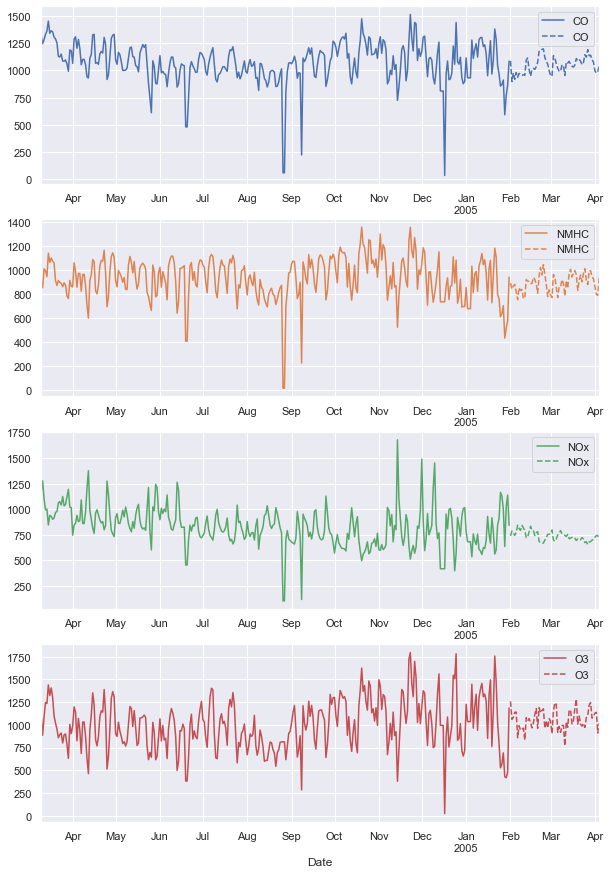

In [127]:
def plot_predictions(data, preds):
    fig, ax = plt.subplots(4, 1, figsize=(10, 15))
    preds_df = pd.DataFrame({
    pd.concat(series).name : pd.concat(series) for series in preds
})
    data[['CO', 'NMHC', 'NOx', 'O3']].plot(subplots=True, ax=ax)
    preds_df.plot(subplots=True, ax =ax, style='--')
plot_predictions(train, preds)